# MODELLING 

This notebook is divided in different parts. 
At the beginning of each paragraph, you will find a short description of what is being done.


1. Test-Train-Validation splits
***
2. Topic Modelling: 


    * 2.2. LSI (or Tf-idf dimensionality reduction with SVD)
    * 2.3. LDA on reduced Tf-idf
    * 2.4. LDA on tokens
***
3. Machine Learning: 


    * 3.1.1. Logistic Regression models
            3.1.1. Basic Features
            3.1.2. Truncated Tf-idf Vector
            3.1.3. Truncated Tf-idf Vector + Basic Features
            3.1.4. LDA on Tf-idf Vector
            3.1.5. LDA on Tokens 
    * 3.2.2. Random Forest models 
            3.2.1. Basic Features
            3.2.2. Truncated Tf-idf Vector
            3.2.3. Truncated Tf-idf Vector + Basic Features
            3.2.4. LDA on Tf-idf Vector
            3.2.5. LDA on Tokens 
    * 3.3.3. Dense Network models
            3.3.1. 2 layers Dense Network model on Truncated Tf-idf Vector + Basic Features
            3.3.2. 3 layers Dense Network Model on Truncated Tf-idf Vector + Basic Features
***
4. Auto ML approaches: 

    * 4.1. Auto ML & Truncated SVD Tfidf Vector + Basic Features
    * 4.2. Auto ML & Full Tfidf vector (sparse vector)
    * 4.3. Auto ML & LDA on reduced Tf-idf
    * 4.4. Auto ML & Raw Text (Auto Keras)
***
5. Summary of the different models outputs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import OrderedDict
import scipy as sc
import re
from pprint import pprint
import sys
from ast import literal_eval

# Sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Nltk 
import nltk
from nltk.corpus import stopwords

# Spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from IPython.display import Image

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Warnings
import warnings
#warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore")

# Topic Modelling
import gensim
from gensim.test.utils import common_dictionary, common_corpus
from gensim.models import TfidfModel
from gensim.models import LsiModel
from gensim.models import LdaModel
from gensim import corpora, models
from gensim.models import CoherenceModel
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import KNeighborsClassifier

#Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from tpot import TPOTClassifier

# Keras 
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
import tensorflow.keras as keras
import autokeras as ak

# Tensorflow
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED']= '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

np.random.seed(37)
rn.seed(1254)

/opt/anaconda3/lib/python3.8/site-packages/aiohttp/helpers.py:107: DeprecationWarning: "@coroutine" decorator is deprecated since Python 3.8, use "async def" instead
  def noop(*args, **kwargs):  # type: ignore
/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
finaldf = pd.read_csv('final_dataset_modelling.csv')

# 1. TRAIN-TEST-VALIDATION 

Here I am dividing the Train and Validation sets from the Test sets. 

This choice is done to **maximize the effects of grid search** and cross validation in my next models. 

I have also decided to keep the samples balanced across the personas, to give to the model equal probabilities of learning how each persona speaks.

In [3]:
finaldf.columns

Index(['date', 'likes', 'retweets', 'tweet', 'tweet_id', 'total_words',
       'total_charact', 'hashtag', 'num_hashtags', 'mentions', 'num_mentions',
       'emojis', 'counter_emojis', 'num_emojis', 'num_upper_words', 'cleaned',
       'final', 'persona', 'year', 'month', 'weekday', 'hour', 'sentiment',
       'sentiment_flag'],
      dtype='object')

In [4]:
finaldf.persona.value_counts()

elon     6024
kim      6024
trump    6024
biden    6024
Name: persona, dtype: int64

In [5]:
# Create X/y arrays
# I am not using the total_charact as it is of no use as seen previously 

X = finaldf[['tweet', 'tweet_id', 'likes', 'retweets', 'total_words', 'num_hashtags', 'num_mentions', 'num_emojis', 
             'num_upper_words', 'final', 'sentiment', 'sentiment_flag']]

y = finaldf['persona']

In [6]:
X_trval, X_test, y_trval, y_test = train_test_split(X,y,
                                                  stratify = np.asarray(y),
                                                  test_size = 0.2,
                                                  random_state = 1)

In [7]:
print("Trval Y Values per persona", np.unique(y_trval, return_counts=True))
print("Test Y Values per persona", np.unique(y_test, return_counts=True))

Trval Y Values per persona (array(['biden', 'elon', 'kim', 'trump'], dtype=object), array([4819, 4819, 4819, 4819]))
Test Y Values per persona (array(['biden', 'elon', 'kim', 'trump'], dtype=object), array([1205, 1205, 1205, 1205]))


# 2. TOPIC MODELLING

For Topic Modelling I am going to use the Bag of Words approach and here are the steps I am taking into topic modelling: 

* I will be reusing the stopwords I have identified previously in the EDA 
* I am then tokenizing the words and removing the stopwords to have a cleaner test. 
* I am then creating the bigrams, which are two words frequently occurring together in the document. 
* I am lemmatizing, meaning that words in third person are changed to first person and verbs in past and future tenses are changed into present, I am keeping only noun, adj, vb, adv.
* I am then removing the null values in the tokens (e.g. those tokens without any bigram)
* I am using Tf-idf vectorization (for LSI and LSA)

I will be using 3 approaches for Topic Modelling: 

1. LSA or LSI - Latent Semantic Analysis or Latent Semantic Index, in which the idea is to take a matrix of the terms identified in the Tweets and decompose it into a separate matrix - I will be tokenizing using Tf-Idf and then using Truncated SVD (singular value decomposition) in order to keep the most significant dimensions (I will be reducing size of the vector)
***
2. LDA - Latent Dirichlet Allocation using the Tf-idf reduced vector from the Truncated SVD 
***
3. LDA - Latend Dirichlet Allocation directly done on the tokens - I am applying LDA directly on the tokens to see if there is a difference in aggregation of data when by-passing the tf-idf vectorization. I am using the Gensim library for this purpose.

In [8]:
# tokenizing the words & cleaning up the text 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words_trval = list(sent_to_words(X_trval.final.to_list()))
data_words_test = list(sent_to_words(X_test.final.to_list()))

In [9]:
# function to remove stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [10]:
# making stop words
stop_words = list(stopwords.words('english'))
stop_words.extend(['amp', 's', 'go', 'be', 'thank', 'go', 
                   'need', 'take', 'get', 'day','make', 'come', 'much', 'guy',
                   'know', 'would', 'see', 'can', 'xo', 'soon', 'sure', 'get', 'got',
                   'look', 'am', 'pm', 'im', 'dont', 'rt', 'us']) 

In [11]:
# removing stopwords
data_words_nostops_trval = remove_stopwords(data_words_trval)
data_words_nostops_test = remove_stopwords(data_words_test)

In [12]:
# building the bigram 
bigram_trval = gensim.models.Phrases(data_words_nostops_trval, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_test = gensim.models.Phrases(data_words_nostops_test, min_count=5, threshold=100) # higher threshold fewer phrases.

# getting the sentences clubbed as a bigram
bigram_mod_trval = gensim.models.phrases.Phraser(bigram_trval)
bigram_mod_test = gensim.models.phrases.Phraser(bigram_test)

In [13]:
# functions to make bigrams & lemmatize
def make_bigrams_trval(texts):
    return [bigram_mod_trval[doc] for doc in texts]

def make_bigrams_test(texts):
    return [bigram_mod_test[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# forming Bigrams
data_words_bigrams_trval = make_bigrams_trval(data_words_nostops_trval)
data_words_bigrams_test = make_bigrams_test(data_words_nostops_test)

# initializing spacy 'en' model, keeping only tagger component (for efficiency)
# I used: python3 -m spacy download en
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

# doing lemmatization keeping only noun, adj, vb, adv
data_lemmatized_trval = lemmatization(data_words_bigrams_trval, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_test = lemmatization(data_words_bigrams_test, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [15]:
# bringing the lemmatized data into the dataframe 
X_trval['tokens'] = data_lemmatized_trval
X_test['tokens'] = data_lemmatized_test

In [16]:
# example of final cleaned tweets and the tokenized tweets
X_trval[['final', 'tokens']].head(10)

,final,tokens
986,last year i had the privilege of walking down ...,"[last, year, privilege, walk, street, greatgre..."
5482,its debate night so ive got my earpiece and pe...,"[debate, night, have, earpiece, performance, e..."
4443,after another night of unrest in america im ho...,"[night, host, virtual, roundtable, mayor, coun..."
11664,congratulations to my daughter ivanka and her ...,"[congratulation, husband, daughter, rise, yest..."
15687,west coast is on in 5 tune in now xo,"[west_coast, tune]"
3793,this is a moment to look out for our neighbors...,"[moment, neighbor, care, elderly, worker, fron..."
16758,sweater weather,[]
5674,i heard its,[hear]
18478,take note,[note]
1961,and i had a great afternoon at the iowa state...,"[afternoon, talk, folk, country, stop]"


In [17]:
# index to be removed from Y (train/test)
index_remove_from_ytrval = X_trval[X_trval.tokens.apply(len) == 0].index 
index_remove_from_ytest = X_test[X_test.tokens.apply(len) == 0].index

In [18]:
# removing empty lists of tokens
X_trval = X_trval[X_trval.tokens.apply(len) != 0].copy()
X_test = X_test[X_test.tokens.apply(len) != 0].copy()

In [19]:
# number of rows to be removed from y as they were not tokenized and the remaining ones
print("Number of empty tokens rows in X_trval", len(index_remove_from_ytrval))
print("Total number of rows in y_trval", len(y_trval))
print("Total number of rows in X_trval", len(X_trval))

print("Number of empty tokens rows in X_test", len(index_remove_from_ytest))
print("Total number of rows in y_test", len(y_test))
print("Total number of rows in X_test", len(X_test))

Number of empty tokens rows in X_trval 1508
Total number of rows in y_trval 19276
Total number of rows in X_trval 17768
Number of empty tokens rows in X_test 362
Total number of rows in y_test 4820
Total number of rows in X_test 4458


In [20]:
# removing y rows which are corresponding to no tokens in X_trval
y_trval = y_trval.loc[~y_trval.index.isin(index_remove_from_ytrval)]
y_test = y_test.loc[~y_test.index.isin(index_remove_from_ytest)]

In [21]:
# number of rows final to be used
print("Total number of rows in y_trval", len(y_trval))
print("Total number of rows in X_trval", len(X_trval))
print("Total number of rows in y_test", len(y_test))
print("Total number of rows in X_test", len(X_test))

Total number of rows in y_trval 17768
Total number of rows in X_trval 17768
Total number of rows in y_test 4458
Total number of rows in X_test 4458


#### TF-IDF Vectorizer

TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency.

It is a statistical measure that evaluates how **relevant** a word is to a document in a collection of documents. 
This is done by multiplying two metrics:

1. **The term frequency of a word in a document**. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. 
***
2. **The inverse document frequency of the word across a set of documents**. This means how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm. So, if the word is very common and appears in many documents, this number will approach 0. Otherwise, it will approach 1.

Multiplying these two numbers results in the TF-IDF score of a word in a document. The higher the score, the more relevant that word is in that particular document.


In [22]:
# needed not to incurr in error with the Tf-idf vectorizer
def identity_tokenizer(text):
    return text

In [23]:
# Tf-idf vectorizer 
tv = TfidfVectorizer(tokenizer=identity_tokenizer, 
                              stop_words='english', 
                              lowercase=False) 

X_trval_tfidf = tv.fit_transform(X_trval.tokens)
X_test_tfidf = tv.transform(X_test.tokens)

In [24]:
# making the vocabulary in my text (X_trval!)
vocab = tv.get_feature_names()
print(vocab[10:20])

['abolish', 'abort', 'abortion', 'abrasion', 'abridge', 'abridged', 'abroad', 'abruptly', 'abs', 'absent']


In [25]:
# vocabulary length
print("Vocabulary length:", len(vocab))

Vocabulary length: 9937


In [26]:
# printing dimensions of Tfidf vectors
print('Training dim:',X_trval_tfidf.shape, 'Test dim:', X_test_tfidf.shape)

Training dim: (17768, 9937) Test dim: (4458, 9937)


My TF-IDF vocabulary consists of 9925 words coming from the X_trval set. 
I have applied the same vectorization to the Test set (tv.transform(X_test.tokens).

## 2.1 LSI - (Tf-idf Dimensionality Reduction with SVD)

I am applying the truncated SVD to term-document matrices (as returned by the TfidfVectorizer), which is also known as latent semantic analysis (LSA or LSI), because it transforms such matrices to a “semantic” space of low dimensionality.

Here, I am reducing the vector from 9K to 400 as this reduction will explain approximately 50% of the variance. 

Potentially I could go higher, but I do not not want to incurr in the unpleasant situation in which my models will take quite a significant amount of time to run. 


If needed, I will come back at this stage and increase the number of vectors.



In [27]:
# reducing the dimensionality of Tf-Idf vector with SVD

svd = TruncatedSVD(n_components=400,
                  n_iter = 10, 
                  random_state = 0)

X_trval_svd = svd.fit_transform(X_trval_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

print('LSA output shape Train:', X_trval_svd.shape)
print('LSA output shape Test:', X_test_svd.shape)

LSA output shape Train: (17768, 400)
LSA output shape Test: (4458, 400)


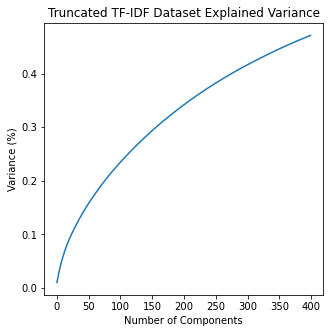

Explained variance of the SVD decomposition: 47%


In [28]:
# plotting the Cumulative Summation of the Explained Variance

plt.figure(figsize=(5, 5))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Truncated TF-IDF Dataset Explained Variance')
plt.show()
print("Explained variance of the SVD decomposition: {}%".format(int(svd.explained_variance_ratio_.sum() * 100)))

## 2.2 LDA on Reduced Tf-idf

The idea behind LDA topic modeling is trying to discover topics that are hidden (latent) in a set of text documents. LDA tries to infer possible topics based on the words in the documents, by using a a generative probabilistic model and Dirichlet distributions.  

The generative probabilisitc model first observes the data, then it generates data that is similar to the observed one in order to understand it (a bit like reverse engineering). This approach goes beyond data description, it really learns how to generate observed data by its characteristic features. This generative process is defined by a joint distribution of hidden and observed variables. 

The other component of LDA is the Dirichlet distributions, which can be thought of a sort of distribution of distributions. In fact there is one Dirichlet distribution which is relate do the multinomial distribution of topics in each document (in this case each tweet have a topic mix). There is a second Dirichlet distribution used in the LDA algorighm which is related to the distribution of the words in each topic. 

With these 2 components, LDA seems to be able to genaralize well new documents after it’s been trained on a given set of documents.

I have searched a bit which would be the best approach to define the best model (e.g. not to manually test different number of topics per model and assessing manually the best model) and I have found that it is also possible to do grid search on LDA. I will be trying to find the best LDA model by specifying a set of number of components and a set of learning rates to see which model could perform better. 

When assessing final model I will be checking these 2 metrics to identify if the model is well performing: 
* Log-likelihood - how plausible model parameters are given the data or in other words how well this model fits a new set of data. 
* Perplexity - model's "surprise" at the data

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.

In [29]:
# define Search Param
search_params = {'n_components': [7, 10, 12, 15], 
                 'learning_decay': [.5, .7, .9]}

# init the Model
lda = LatentDirichletAllocation(max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0)

# init Grid Search Class
model = GridSearchCV(lda, 
                     param_grid=search_params, 
                     verbose = 1)

# do the Grid Search
model.fit(X_trval_tfidf)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  8.7min finished


GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 learning_offset=50.0,
                                                 max_iter=5, random_state=0),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [7, 10, 12, 15]},
             verbose=1)

In [30]:
# best Model
best_lda_model = model.best_estimator_

# model Parameters
print("Best Model's Params: ", model.best_params_)

# log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X_trval_tfidf))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 7}
Best Log Likelihood Score:  -90048.91055262911
Model Perplexity:  10684.914272599


In [31]:
# pringing the parameters of the best model
pprint(best_lda_model.get_params())

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.9,
 'learning_method': 'online',
 'learning_offset': 50.0,
 'max_doc_update_iter': 100,
 'max_iter': 5,
 'mean_change_tol': 0.001,
 'n_components': 7,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


The best model has 7 topics and a learning rate of 0.9. I will be doing a bit of investigation on the results of the LDA before proceeding to modelling. 

In [32]:
# fit and fit_transform of train and test data
X_trval_lda = best_lda_model.fit_transform(X_trval_tfidf)
X_test_lda = best_lda_model.transform(X_test_tfidf)

In [33]:
# useful way to display the topics found
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, X_trval_tfidf, vectorizer = tv, mds='mmds', n_jobs = 1)
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.061933 -0.266726       1        1  57.318834
6     -0.198857  0.068182       2        1   8.963596
3      0.140340  0.151730       3        1   7.909328
5      0.178330 -0.064921       4        1   7.150190
1      0.052900  0.008402       5        1   6.521688
0     -0.078502 -0.041548       6        1   6.224097
4     -0.032278  0.144881       7        1   5.912268, topic_info=           Term        Freq       Total Category  logprob  loglift
8786      thank  156.000000  156.000000  Default  30.0000  30.0000
3705       good  205.000000  205.000000  Default  29.0000  29.0000
9093       true  108.000000  108.000000  Default  28.0000  28.0000
1546       come  110.000000  110.000000  Default  27.0000  27.0000
9602       vote  120.000000  120.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
4701       joke    7.173470   13.713063   Topic7  -5.7931   2.1802
7430     rocket   10.205288   25.262199   Topic7  -5.4406   1.9217
7557  satellite    4.947749    7.654736   Topic7  -6.1645   2.3917
5042       list    5.471043   12.924273   Topic7  -6.0640   1.9685
5032        lip    5.174729   10.112239   Topic7  -6.1197   2.1582

[395 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
23        1  0.298014  absolutely
23        2  0.655631  absolutely
99        1  0.488762    actually
99        2  0.458215    actually
99        4  0.030548    actually
...     ...       ...         ...
9835      5  0.983807     workout
9890      1  0.944459        year
9890      2  0.009170        year
9890      3  0.018339        year
9890      5  0.018339        year

[586 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 4, 6, 2, 1, 5])

Below I am showcasing the visualization of the topics with pyLDAvis, in case the package is not downloaded

![title](plydavis.png)

The **left** part of this chart represents the Intertopic Distance Map, which is the distance between all the topics, as the plot is rendered in two dimensions according to multidimensional scaling (MDS). Topics that are generally similar should be closer in the plot, whereas dissimilar topics should be displayed apart. The size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus.

Here we can see that topic 1 is the most frequent topic in the whole corpus and that overall the LDA does a good job in differentiating the topics (they are in each quadrant of the Distance Map). 


The **right** part represents the top terms or the most relevant terms in the corpus (how frequent and how distinctive a term is in distinguishing different topics). The relevance metric is controlled by the **parameter λλ**. 

Setting the λλ parameter **close to 1.0** (the default) will rank the terms solely according to their **probability within the topic**.
Setting λλ **close to 0.0** will rank the terms solely according to their **"distinctiveness"** within the topic — i.e., terms that occur only in this topic, and do not occur in other topics.

Setting λλ to values between 0.0 and 1.0 will result in an intermediate ranking, weighting term probability and distinctiveness accordingly.


In [34]:
# deep dive into the 7 topics 

n_words = 15
feature_names = tv.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(best_lda_model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")

Topic 0: thank good morning night point tomorrow ready fantastic video doll vibe great sooo ticket kit
Topic 1: come vote pic update shoot workout dress early min today eat comment armenian new fab
Topic 2: love great s time people work today country say president good year make trump job
Topic 3: watch look tonight cool interview agree happy collection enjoy sell shop excited fun wait available
Topic 4: land idea red exciting endorse study rocket landing heavy selfie bag alien joke recommend paint
Topic 5: guy amazing beautiful episode nice app definitely launch crazy favorite interesting view love new visit
Topic 6: true pretty model maybe let course bad play engine actually cut high time feel absolutely


The topics don't look amazing unfortunately! 
It seems like the topics are somehow related to these macro-categories: 

* fashion & beauty
* shopping & lifestyle
* cars & leisure
* celebrations & memories
* elections & presidents
* fun and excitement


I will be doing a bit more investigation to see if I can find discriminant topics across personas or sentiment.


In [35]:
# column names
topicnames = ['Topic ' + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ['Tweet ' + str(i) for i in range(len(X_trval))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(X_trval_lda, 2), columns = topicnames)

# Get dominant topic for each document - I am using the argmax
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [36]:
# dominant topic
df_document_topic.head(5)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,dominant_topic
0,0.04,0.48,0.30,0.04,0.04,0.04,0.04,1
1,0.75,0.04,0.04,0.04,0.04,0.04,0.04,0
2,0.04,0.04,0.65,0.16,0.04,0.04,0.04,2
3,0.04,0.04,0.73,0.04,0.04,0.04,0.04,2
4,0.06,0.06,0.29,0.06,0.41,0.06,0.06,4


Note: I the following cells I am going to do some additional EDA on topics on the identified 'dominant topic'.

This however has a downside. 

Indeed it is not always possible to identify the dominant topics and some times the dominant topic is at parity across topics. In this case the following EDA will not be very informative. In future developments I could be working on setting a threshold for which I can assume a 'dominant topic' or dominant topics.

In [37]:
# creating dfs to perform additional EDA on topics 
eda_df = pd.concat([X_trval.reset_index(), df_document_topic.reset_index()], axis = 1)
eda_df = pd.concat([eda_df.reset_index(), y_trval.reset_index()], axis =1)

In [38]:
# checking the distribution of sentiment over the topics 
eda_df.groupby(['dominant_topic'])['sentiment_flag'].value_counts().to_frame()

sentiment_flag
dominant_topic sentiment_flag                
0              neutral                    521
               positive                   260
               negative                    24
1              neutral                    494
               positive                   197
               negative                    20
2              neutral                   5966
               positive                  4923
               negative                  1623
3              neutral                    631
               positive                   423
               negative                    36
4              neutral                    353
               positive                    92
               negative                    27
5              neutral                    471
               positive                   378
               negative                    46
6              neutral                    876
               positive                   291
               negative                   116

It seems like there is no striking result when we look at the distribution of sentiment score across topics. They are all usually neutral/positive. This is probably an indicator that LDA is not going to perform well in my Machine Learning Models.

In [39]:
# checking the distribution of topics across personas
eda_df.groupby(['persona'])['dominant_topic'].value_counts().to_frame()

dominant_topic
persona dominant_topic                
biden   2                         4391
        6                          106
        0                           69
        3                           59
        1                           42
        5                           37
        4                           16
elon    2                         2441
        6                          611
        3                          308
        4                          224
        0                          222
        1                          204
        5                          197
kim     2                         2119
        3                          530
        5                          495
        1                          357
        6                          323
        0                          308
        4                          146
trump   2                         3561
        6                          243
        0                          206
        3                          193
        5                          166
        1                          108
        4                           86

Again, there is no striking effect on the distribution of topics per persona either! It seems like each of the personas is having similar patterns of discussion.

Even if we take a look and check per each of the 4 personas the distribution of topics and sentiment, there results are pretty flat and there is no substantial information to be regarded as important (see below the example on Trump, which is not different from the others). 


In [40]:
eda_df[eda_df.persona == 'trump'].groupby(['sentiment_flag', 'persona'])['dominant_topic'].value_counts().to_frame()

dominant_topic
sentiment_flag persona dominant_topic                
negative       trump   2                          618
                       6                           43
                       5                           18
                       0                           11
                       4                           11
                       3                            9
                       1                            6
neutral        trump   2                         1480
                       6                          138
                       0                          117
                       3                           88
                       5                           76
                       1                           67
                       4                           55
positive       trump   2                         1463
                       3                           96
                       0                           78
                       5                           72
                       6                           62
                       1                           35
                       4                           20

Perhaps the LDA is not the best approach to text classification and topic modelling as it is not giving encouraging results. 
I will be assessing its validity in the modelling part. 

I will now try to run an LDA model directly on the tokens to see if there is any variation vs. the LDA built on the Tf-idf reduced vectors.

## 2.3 LDA on Tokens 

In [41]:
# creating a dictionary and corpus
dictionary = corpora.Dictionary(X_trval.tokens)
corpus = [dictionary.doc2bow(text) for text in X_trval.tokens]

In [42]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    
    lm_list = []
    
    for num_topics in range(1, limit):
        lm = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                             num_topics=num_topics, 
                                             id2word=dictionary,
                                             random_state=0)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

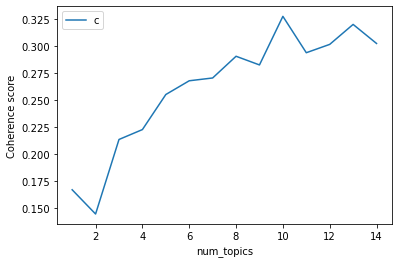

CPU times: user 1min 12s, sys: 1.38 s, total: 1min 13s
Wall time: 3min 2s


In [43]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=X_trval.tokens, limit=15)

In [44]:
# building final LDA model with full corpus 
best_lda_model_full = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word = dictionary,
                                           num_topics=10, 
                                           random_state=0)

In [45]:
# printing the topics 
pprint(best_lda_model_full.print_topics())

[(0,
  '0.022*"country" + 0.017*"vote" + 0.017*"back" + 0.016*"president" + '
  '0.016*"build" + 0.016*"say" + 0.015*"work" + 0.015*"well" + 0.013*"run" + '
  '0.013*"can"'),
 (1,
  '0.014*"bad" + 0.012*"job" + 0.011*"right" + 0.010*"people" + 0.010*"must" + '
  '0.010*"country" + 0.010*"tell" + 0.009*"enough" + 0.009*"nation" + '
  '0.009*"good"'),
 (2,
  '0.021*"today" + 0.020*"year" + 0.017*"s" + 0.015*"stand" + 0.014*"nation" + '
  '0.013*"people" + 0.011*"work" + 0.010*"proud" + 0.010*"fight" + '
  '0.010*"together"'),
 (3,
  '0.045*"love" + 0.018*"watch" + 0.015*"go" + 0.013*"live" + 0.012*"family" + '
  '0.011*"time" + 0.010*"great" + 0.010*"s" + 0.009*"come" + 0.009*"look"'),
 (4,
  '0.025*"thank" + 0.012*"hear" + 0.011*"good" + 0.011*"wait" + 0.010*"feel" + '
  '0.010*"miss" + 0.009*"open" + 0.009*"new" + 0.008*"go" + 0.008*"already"'),
 (5,
  '0.049*"great" + 0.013*"help" + 0.013*"work" + 0.013*"really" + 0.013*"want" '
  '+ 0.011*"s" + 0.010*"give" + 0.009*"follow" + 0.009*"

In [46]:
# clearer visualization of words in topics
for topic_id in range(best_lda_model_full.num_topics):
    topk = best_lda_model_full.show_topic(topic_id, 10)
    topk_words = [ w for w, _ in topk ]
    
    print('{}: {}'.format(topic_id, ' '.join(topk_words)))

0: country vote back president build say work well run can
1: bad job right people must country tell enough nation good
2: today year s stand nation people work proud fight together
3: love watch go live family time great s come look
4: thank hear good wait feel miss open new go already
5: great help work really want s give follow need today
6: good time go ever car get hope make show night
7: tonight be never think people let go guy excited watch
8: call launch fun take free away report check seem video
9: true test lose good may use point start even money


In [47]:
# nice visualization of topics
pyLDAvis.gensim.prepare(best_lda_model_full, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.081183 -0.003801       1        1  12.831482
0      0.152312 -0.040978       2        1  12.781459
9     -0.075047 -0.120080       3        1  10.836211
5      0.035774  0.031503       4        1  10.539632
3      0.016635  0.099929       5        1  10.349794
1      0.140035 -0.052814       6        1  10.023195
6     -0.056929 -0.172371       7        1   9.341047
7     -0.008213  0.198001       8        1   8.352001
8     -0.244272  0.017395       9        1   7.681939
4     -0.041479  0.043216      10        1   7.263242, topic_info=        Term        Freq       Total Category  logprob  loglift
259     love  735.000000  735.000000  Default  30.0000  30.0000
142    great  958.000000  958.000000  Default  29.0000  29.0000
188  tonight  440.000000  440.000000  Default  28.0000  28.0000
121    thank  334.000000  334.000000  Default  27.0000  27.0000
96     watch  386.000000  386.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
446     back   59.388611  497.534607  Topic10  -5.0352   0.4968
181    right   54.723083  396.420898  Topic10  -5.1170   0.6422
87         s   56.624760  824.691040  Topic10  -5.0829  -0.0562
103    start   48.883102  343.976501  Topic10  -5.2299   0.6712
400      big   47.427979  400.157715  Topic10  -5.2601   0.4897

[727 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1890      1  0.984464    ability
399       6  0.218017       able
399       7  0.287386       able
399       8  0.009910       able
399       9  0.475674       able
...     ...       ...        ...
25        4  0.148736  yesterday
25        5  0.191232  yesterday
25        7  0.042496  yesterday
25        8  0.541824  yesterday
25       10  0.010624  yesterday

[2110 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 10, 6, 4, 2, 7, 8, 9, 5])

Below I am showcasing the visualization of the topics (LDA on tokens):





![title](pydavis_lda_full.png)

In [48]:
# compute Perplexity
print('\nPerplexity: ', best_lda_model_full.log_perplexity(corpus))

# compute Coherence Score
coherence_model_lda = CoherenceModel(model=best_lda_model_full, 
                                     texts=X_trval.tokens, 
                                     dictionary=dictionary, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.70364672158866

Coherence Score:  0.32732275134329425


In [49]:
# create corpus for Test set using the Dictionary from the Train 
corpus_test = [dictionary.doc2bow(text) for text in X_test.tokens]

In [50]:
# getting topics for both Train and Test data
X_trval_lda_full = best_lda_model_full.get_document_topics(corpus)
X_test_lda_full = best_lda_model_full.get_document_topics(corpus_test)

In [51]:
# printing topics
for topic in X_trval_lda_full:
      print(topic)

[(0, 0.2740093), (1, 0.012187019), (2, 0.62849295), (3, 0.012187803), (4, 0.01218698), (5, 0.012187195), (6, 0.012187032), (7, 0.0121869985), (8, 0.012187498), (9, 0.012187233)]
[(0, 0.015157725), (1, 0.015152505), (2, 0.015153432), (3, 0.86361426), (4, 0.015152073), (5, 0.015155456), (6, 0.015159198), (7, 0.015153076), (8, 0.015150571), (9, 0.015151717)]
[(0, 0.011117249), (1, 0.0111151785), (2, 0.011114934), (3, 0.40639594), (4, 0.011113903), (5, 0.011117666), (6, 0.011120796), (7, 0.50467205), (8, 0.01111869), (9, 0.011113564)]
[(0, 0.016669003), (1, 0.016669003), (2, 0.41301355), (3, 0.016670605), (4, 0.016671963), (5, 0.01666946), (6, 0.016669126), (7, 0.45362028), (8, 0.016678033), (9, 0.016669003)]
[(0, 0.033340782), (1, 0.03334056), (2, 0.033340603), (3, 0.365309), (4, 0.03334069), (5, 0.36795935), (6, 0.03334056), (7, 0.033344228), (8, 0.033343654), (9, 0.03334056)]
[(2, 0.73135835), (4, 0.1235828), (6, 0.09836822)]
[(0, 0.050004758), (1, 0.050000574), (2, 0.05000281), (3, 0.0

[(9, 0.9459434)]
[(0, 0.024918018), (1, 0.024918437), (2, 0.024918638), (3, 0.7757089), (4, 0.024919149), (5, 0.02491799), (6, 0.024925217), (7, 0.024920644), (8, 0.024934603), (9, 0.024918357)]
[(0, 0.019042816), (1, 0.019049888), (2, 0.019042788), (3, 0.01904315), (4, 0.48445514), (5, 0.36319613), (6, 0.019042559), (7, 0.019042514), (8, 0.019042531), (9, 0.019042451)]
[(0, 0.025002336), (1, 0.025002336), (2, 0.025002336), (3, 0.025002336), (4, 0.025002336), (5, 0.025002336), (6, 0.025002336), (7, 0.025002336), (8, 0.77497894), (9, 0.025002336)]
[(0, 0.101993084), (4, 0.042974852), (5, 0.4578396), (6, 0.2620644), (9, 0.11493857)]
[(0, 0.025008969), (1, 0.025007935), (2, 0.025007512), (3, 0.025006799), (4, 0.025007417), (5, 0.025006898), (6, 0.02500786), (7, 0.5252093), (8, 0.025007118), (9, 0.27473015)]
[(0, 0.011727169), (1, 0.011723696), (2, 0.26521373), (3, 0.15643562), (4, 0.4962824), (5, 0.011722554), (6, 0.011723873), (7, 0.011723334), (8, 0.011721483), (9, 0.011726135)]
[(0, 0.

[(0, 0.013726726), (1, 0.09470611), (2, 0.013727889), (3, 0.013727198), (4, 0.013726941), (5, 0.013741983), (6, 0.15248466), (7, 0.65670264), (8, 0.0137293525), (9, 0.013726511)]
[(0, 0.0999968), (1, 0.100026384), (2, 0.0999968), (3, 0.09999694), (4, 0.099997446), (5, 0.09999696), (6, 0.099997096), (7, 0.099997185), (8, 0.09999739), (9, 0.09999697)]
[(0, 0.5499487), (1, 0.0500017), (2, 0.050010577), (3, 0.05000294), (4, 0.050005242), (5, 0.05001028), (6, 0.050006412), (7, 0.050001863), (8, 0.050010927), (9, 0.05000136)]
[(0, 0.025001474), (1, 0.025001876), (2, 0.02500262), (3, 0.025016999), (4, 0.025002977), (5, 0.025002047), (6, 0.025001578), (7, 0.025008606), (8, 0.7749605), (9, 0.025001295)]
[(0, 0.050000843), (1, 0.54998195), (2, 0.050000843), (3, 0.05000085), (4, 0.050000843), (5, 0.050001793), (6, 0.050000876), (7, 0.0500058), (8, 0.050000843), (9, 0.050005388)]
[(0, 0.03333952), (1, 0.033338126), (2, 0.6999781), (3, 0.033336), (4, 0.033334766), (5, 0.03333494), (6, 0.033334564),

[(0, 0.020002162), (1, 0.020002535), (2, 0.020003213), (3, 0.02001606), (4, 0.020002123), (5, 0.020004265), (6, 0.02000416), (7, 0.8199608), (8, 0.020002352), (9, 0.020002328)]
[(0, 0.030736903), (1, 0.03073756), (2, 0.03073489), (3, 0.7233731), (4, 0.030734917), (5, 0.030734895), (6, 0.030736748), (7, 0.030734906), (8, 0.03073503), (9, 0.030741021)]
[(1, 0.2798316), (8, 0.5683741), (9, 0.09608205)]
[(0, 0.59812355), (2, 0.15216866), (3, 0.19969352)]
[(0, 0.01251517), (1, 0.8873962), (2, 0.012511623), (3, 0.012515022), (4, 0.01250978), (5, 0.01250931), (6, 0.012509176), (7, 0.01251293), (8, 0.012510167), (9, 0.012510588)]
[(0, 0.050005272), (1, 0.050005272), (2, 0.54995257), (3, 0.050005272), (4, 0.050005272), (5, 0.050005272), (6, 0.050005272), (7, 0.050005272), (8, 0.050005272), (9, 0.050005272)]
[(0, 0.388), (1, 0.45197988), (2, 0.02000353), (3, 0.02000114), (4, 0.020004354), (5, 0.020004822), (6, 0.020001544), (7, 0.020001903), (8, 0.020001015), (9, 0.020001862)]
[(0, 0.025002116),

[(0, 0.033334527), (1, 0.033334527), (2, 0.03333455), (3, 0.03333821), (4, 0.033334956), (5, 0.03333492), (6, 0.03333463), (7, 0.3668807), (8, 0.3664384), (9, 0.03333463)]
[(0, 0.020008937), (1, 0.8199188), (2, 0.020008937), (3, 0.020008937), (4, 0.020008937), (5, 0.020009005), (6, 0.02000894), (7, 0.020009317), (8, 0.020008937), (9, 0.02000928)]
[(0, 0.9399726)]
[(0, 0.010899586), (1, 0.010901841), (2, 0.010901276), (3, 0.20986092), (4, 0.16348404), (5, 0.17748356), (6, 0.38376638), (7, 0.010901564), (8, 0.010899688), (9, 0.0109011745)]
[(5, 0.82805824), (9, 0.09916911)]
[(0, 0.016670728), (1, 0.016669897), (2, 0.016668284), (3, 0.016670266), (4, 0.016668387), (5, 0.8499761), (6, 0.016669331), (7, 0.016668515), (8, 0.016667878), (9, 0.016670572)]
[(1, 0.80376077), (6, 0.15798838)]
[(0, 0.011253584), (1, 0.011254228), (2, 0.14152938), (3, 0.011250154), (4, 0.13003449), (5, 0.011251119), (6, 0.4929145), (7, 0.16801038), (8, 0.011252048), (9, 0.0112501485)]
[(0, 0.38358155), (1, 0.012479

[(0, 0.012501827), (1, 0.012501993), (2, 0.012501927), (3, 0.0125019215), (4, 0.012501885), (5, 0.012501827), (6, 0.012501896), (7, 0.3443693), (8, 0.012501827), (9, 0.5556156)]
[(0, 0.016669655), (1, 0.3183037), (2, 0.016676715), (3, 0.01667162), (4, 0.19905041), (5, 0.016671551), (6, 0.01667188), (7, 0.016669689), (8, 0.36593893), (9, 0.016675854)]
[(0, 0.03141754), (1, 0.03141722), (2, 0.031417713), (3, 0.031417288), (4, 0.031417355), (5, 0.031428315), (6, 0.03142634), (7, 0.35106188), (8, 0.39757186), (9, 0.031424474)]
[(0, 0.18893455), (1, 0.01667421), (2, 0.01668346), (3, 0.016676286), (4, 0.016675636), (5, 0.5143226), (6, 0.016674753), (7, 0.016686426), (8, 0.016674275), (9, 0.17999782)]
[(0, 0.03333506), (1, 0.03333506), (2, 0.03333886), (3, 0.033336725), (4, 0.033335805), (5, 0.03333506), (6, 0.36663), (7, 0.033335518), (8, 0.3666664), (9, 0.03335149)]
[(0, 0.7663799), (9, 0.16088171)]
[(0, 0.014298626), (1, 0.014299069), (2, 0.01429007), (3, 0.014308083), (4, 0.014290186), (5

[(0, 0.01250553), (1, 0.012505527), (2, 0.64786375), (3, 0.012505194), (4, 0.10918116), (5, 0.012505057), (6, 0.012505076), (7, 0.012506462), (8, 0.012508068), (9, 0.15541421)]
[(0, 0.015880996), (1, 0.015880836), (2, 0.015881028), (3, 0.85706055), (4, 0.015881186), (5, 0.015885428), (6, 0.015886994), (7, 0.015881004), (8, 0.015880996), (9, 0.015880926)]
[(2, 0.79558367), (4, 0.10826807), (9, 0.06319505)]
[(0, 0.025001796), (1, 0.025001539), (2, 0.02500514), (3, 0.44741422), (4, 0.025010047), (5, 0.025001545), (6, 0.02500249), (7, 0.025001874), (8, 0.3525575), (9, 0.02500383)]
[(0, 0.50314784), (1, 0.014295087), (2, 0.14835031), (3, 0.014295668), (4, 0.014292314), (5, 0.014293269), (6, 0.014291429), (7, 0.0142939845), (8, 0.014291426), (9, 0.24844867)]
[(0, 0.033397455), (1, 0.033397455), (2, 0.033397455), (3, 0.0334085), (4, 0.38553146), (5, 0.033410218), (6, 0.34726506), (7, 0.033397455), (8, 0.033397455), (9, 0.033397455)]
[(0, 0.050003458), (1, 0.050004385), (2, 0.050011925), (3, 0

[(3, 0.4395201), (7, 0.3010412), (9, 0.20108981)]
[(0, 0.050014555), (1, 0.050014555), (2, 0.050014555), (3, 0.050014555), (4, 0.050014555), (5, 0.050014555), (6, 0.050014555), (7, 0.050014555), (8, 0.050014555), (9, 0.549869)]
[(0, 0.017046684), (1, 0.017044393), (2, 0.017043214), (3, 0.4350296), (4, 0.42861044), (5, 0.017045544), (6, 0.01704326), (7, 0.0170514), (8, 0.017042587), (9, 0.017042859)]
[(0, 0.033340044), (1, 0.03333934), (2, 0.03333759), (3, 0.0333365), (4, 0.69997114), (5, 0.033334956), (6, 0.0333352), (7, 0.033334993), (8, 0.03333513), (9, 0.033335056)]
[(2, 0.44754842), (9, 0.47394696)]
[(0, 0.05000603), (1, 0.5498407), (2, 0.050021354), (3, 0.050020795), (4, 0.05002421), (5, 0.05000603), (6, 0.050019052), (7, 0.050016902), (8, 0.050026298), (9, 0.050018635)]
[(0, 0.050011076), (1, 0.050011076), (2, 0.050011076), (3, 0.050011076), (4, 0.050011076), (5, 0.54990035), (6, 0.050011076), (7, 0.050011076), (8, 0.05001108), (9, 0.050011076)]
[(0, 0.02001005), (1, 0.020012949)

[(0, 0.84993225), (1, 0.01667319), (2, 0.016674653), (3, 0.01667303), (4, 0.016673883), (5, 0.01667509), (6, 0.016673202), (7, 0.016676115), (8, 0.016673012), (9, 0.016675595)]
[(0, 0.050002474), (1, 0.050000716), (2, 0.5499855), (3, 0.05000264), (4, 0.05000075), (5, 0.050002307), (6, 0.050000716), (7, 0.050002776), (8, 0.050001245), (9, 0.0500008)]
[(0, 0.3094449), (2, 0.35019085), (5, 0.13849154), (7, 0.15184022)]
[(0, 0.08729926), (2, 0.07771341), (6, 0.11795409), (8, 0.25628167), (9, 0.43135664)]
[(0, 0.025007037), (1, 0.02500228), (2, 0.025003953), (3, 0.02500157), (4, 0.025004582), (5, 0.02500148), (6, 0.77495295), (7, 0.02502243), (8, 0.02500206), (9, 0.025001641)]
[(0, 0.010007534), (1, 0.25557914), (2, 0.010007613), (3, 0.3627265), (4, 0.0100062275), (5, 0.010006506), (6, 0.010007041), (7, 0.13602383), (8, 0.010005466), (9, 0.18563013)]
[(0, 0.14766422), (1, 0.5143068), (2, 0.14212851), (8, 0.15303622)]
[(0, 0.5624763), (1, 0.26701304), (8, 0.11557945)]
[(0, 0.5499564), (1, 0.

[(2, 0.43123752), (3, 0.38318768), (6, 0.13555488)]
[(0, 0.033336032), (1, 0.36666942), (2, 0.03333653), (3, 0.033336032), (4, 0.03333607), (5, 0.033336032), (6, 0.36664134), (7, 0.033336032), (8, 0.0333365), (9, 0.033336032)]
[(0, 0.012511758), (1, 0.012503345), (2, 0.012505154), (3, 0.6639379), (4, 0.012504164), (5, 0.012508314), (6, 0.012505367), (7, 0.012503484), (8, 0.23601575), (9, 0.012504733)]
[(0, 0.3998361), (1, 0.44012186), (2, 0.02000528), (3, 0.020005757), (4, 0.020006303), (5, 0.02000602), (6, 0.020007754), (7, 0.020003254), (8, 0.020004459), (9, 0.02000322)]
[(0, 0.033338506), (1, 0.033336084), (2, 0.033336133), (3, 0.033335365), (4, 0.24538857), (5, 0.0333354), (6, 0.033342503), (7, 0.03333805), (8, 0.033338994), (9, 0.48791036)]
[(0, 0.05000422), (1, 0.050003428), (2, 0.050001234), (3, 0.050005157), (4, 0.050001483), (5, 0.050001647), (6, 0.050001215), (7, 0.050001215), (8, 0.050004955), (9, 0.5499754)]
[(0, 0.033337966), (1, 0.0333359), (2, 0.03337241), (3, 0.11212311

[(0, 0.25988296), (1, 0.02000243), (2, 0.020002475), (3, 0.020002708), (4, 0.020003263), (5, 0.5800958), (6, 0.020002747), (7, 0.02000292), (8, 0.02000231), (9, 0.020002322)]
[(0, 0.16719921), (1, 0.34949824), (4, 0.11621395), (5, 0.106355846), (6, 0.119605586), (9, 0.11890673)]
[(0, 0.014287624), (1, 0.43629047), (2, 0.014287627), (3, 0.014290676), (4, 0.01428881), (5, 0.014289385), (6, 0.014292653), (7, 0.014289089), (8, 0.014288522), (9, 0.44939515)]
[(1, 0.42074263), (6, 0.3001369), (8, 0.21546084)]
[(0, 0.032650653), (1, 0.70611155), (2, 0.032649487), (3, 0.03265396), (4, 0.032651316), (5, 0.03266504), (6, 0.0326462), (7, 0.032672975), (8, 0.032649573), (9, 0.032649256)]
[(0, 0.012446189), (1, 0.14673583), (2, 0.012444503), (3, 0.012444274), (4, 0.012444402), (5, 0.012444688), (6, 0.26123178), (7, 0.012447508), (8, 0.5049157), (9, 0.01244508)]
[(0, 0.050004847), (1, 0.050000716), (2, 0.5499662), (3, 0.050001353), (4, 0.050002225), (5, 0.050004907), (6, 0.050002426), (7, 0.05000133

[(0, 0.05000016), (1, 0.050001092), (2, 0.050001357), (3, 0.5499921), (4, 0.05000029), (5, 0.050000604), (6, 0.05000028), (7, 0.05000332), (8, 0.050000165), (9, 0.05000061)]
[(0, 0.050021652), (1, 0.050021652), (2, 0.050021652), (3, 0.050021652), (4, 0.050021652), (5, 0.050021652), (6, 0.050021652), (7, 0.050021652), (8, 0.050021652), (9, 0.54980516)]
[(0, 0.05002292), (1, 0.050006073), (2, 0.050004955), (3, 0.050004955), (4, 0.050004955), (5, 0.050004955), (6, 0.5499363), (7, 0.050004955), (8, 0.050004955), (9, 0.050004978)]
[(0, 0.03312441), (1, 0.033121012), (2, 0.033125684), (3, 0.03311479), (4, 0.03311484), (5, 0.033114795), (6, 0.033115342), (7, 0.03311508), (8, 0.7019393), (9, 0.033114795)]
[(0, 0.03333444), (1, 0.033334434), (2, 0.03333448), (3, 0.03335085), (4, 0.69996005), (5, 0.03333599), (6, 0.033334803), (7, 0.033334658), (8, 0.03333628), (9, 0.033343986)]
[(0, 0.22538958), (1, 0.65246856), (5, 0.075670555)]
[(0, 0.020002862), (1, 0.020007212), (2, 0.2351785), (3, 0.229880

[(0, 0.010006915), (1, 0.20372875), (2, 0.010010133), (3, 0.27419406), (4, 0.010008106), (5, 0.010008833), (6, 0.010006588), (7, 0.010009416), (8, 0.010007554), (9, 0.45201966)]
[(1, 0.48507175), (2, 0.1957033), (3, 0.2780838)]
[(0, 0.033335693), (1, 0.03333727), (2, 0.03333825), (3, 0.03333576), (4, 0.36698762), (5, 0.0333364), (6, 0.03333465), (7, 0.033339903), (8, 0.3663174), (9, 0.03333711)]
[(7, 0.5322176), (9, 0.3880814)]
[(0, 0.7749747), (1, 0.025003323), (2, 0.025007667), (3, 0.025002412), (4, 0.025000872), (5, 0.02500236), (6, 0.025001196), (7, 0.025001593), (8, 0.025004862), (9, 0.025000958)]
[(0, 0.033336226), (1, 0.033336226), (2, 0.033336226), (3, 0.033336226), (4, 0.033336226), (5, 0.033336226), (6, 0.033336226), (7, 0.69997394), (8, 0.033336226), (9, 0.033336226)]
[(0, 0.5253714), (1, 0.02502708), (2, 0.02502708), (3, 0.025027158), (4, 0.02502708), (5, 0.02502708), (6, 0.0250279), (7, 0.27440497), (8, 0.025033211), (9, 0.02502708)]
[(0, 0.02500272), (1, 0.025004122), (2,

[(1, 0.2547943), (2, 0.47307503), (3, 0.20873657)]
[(0, 0.011120961), (1, 0.24024191), (2, 0.011126213), (3, 0.011121051), (4, 0.22055733), (5, 0.011121817), (6, 0.4613475), (7, 0.011120878), (8, 0.011120867), (9, 0.011121464)]
[(0, 0.019940816), (1, 0.01993649), (2, 0.019940782), (3, 0.019938197), (4, 0.019938827), (5, 0.019939693), (6, 0.019941203), (7, 0.572008), (8, 0.01993618), (9, 0.26847982)]
[(0, 0.14272407), (6, 0.39233348), (7, 0.3950271)]
[(0, 0.014214229), (1, 0.0142135825), (2, 0.3019194), (3, 0.0142132025), (4, 0.28096732), (5, 0.01421319), (6, 0.01421385), (7, 0.0142162265), (8, 0.16777481), (9, 0.16405416)]
[(2, 0.16727376), (5, 0.5886957), (7, 0.057653476), (9, 0.13634484)]
[(0, 0.050005533), (1, 0.050001994), (2, 0.5499586), (3, 0.05000665), (4, 0.050000727), (5, 0.0500098), (6, 0.050004117), (7, 0.050001632), (8, 0.050008193), (9, 0.050002743)]
[(0, 0.42617244), (5, 0.4944929)]
[(0, 0.2240577), (1, 0.65202826), (8, 0.08277436)]
[(0, 0.01110381), (1, 0.34203115), (2, 

[(0, 0.5403568), (4, 0.091903105), (6, 0.3093823)]
[(0, 0.016667906), (1, 0.016667675), (2, 0.016669462), (3, 0.56680423), (4, 0.016669415), (5, 0.016676603), (6, 0.01667047), (7, 0.016668465), (8, 0.29983655), (9, 0.01666926)]
[(0, 0.05000172), (1, 0.05000172), (2, 0.050002042), (3, 0.54998416), (4, 0.05000172), (5, 0.05000172), (6, 0.05000172), (7, 0.05000172), (8, 0.05000172), (9, 0.05000172)]
[(0, 0.19273134), (1, 0.01667207), (2, 0.016671153), (3, 0.016675904), (4, 0.016672129), (5, 0.016677786), (6, 0.016673362), (7, 0.016672155), (8, 0.4947888), (9, 0.1957653)]
[(0, 0.16261296), (2, 0.34066927), (6, 0.18474977), (8, 0.16750999), (9, 0.10872424)]
[(0, 0.050000332), (1, 0.050000314), (2, 0.05000048), (3, 0.05000033), (4, 0.5499897), (5, 0.05000618), (6, 0.050000317), (7, 0.050000284), (8, 0.05000178), (9, 0.050000284)]
[(0, 0.05000024), (1, 0.050000217), (2, 0.05000031), (3, 0.0500002), (4, 0.050001044), (5, 0.050002333), (6, 0.05000048), (7, 0.54999435), (8, 0.050000563), (9, 0.0

[(0, 0.019878559), (1, 0.01987994), (2, 0.019882225), (3, 0.019878162), (4, 0.019879041), (5, 0.28745815), (6, 0.019893456), (7, 0.5534913), (8, 0.019879622), (9, 0.019879507)]
[(0, 0.09999973), (1, 0.09999998), (2, 0.09999973), (3, 0.099999875), (4, 0.10000038), (5, 0.0999999), (6, 0.10000003), (7, 0.10000012), (8, 0.10000032), (9, 0.099999905)]
[(0, 0.2549325), (1, 0.21089718), (2, 0.28879017), (4, 0.06655597), (7, 0.08714338), (9, 0.0702181)]
[(0, 0.011097285), (1, 0.011095986), (2, 0.011102071), (3, 0.011097681), (4, 0.21703672), (5, 0.16701439), (6, 0.011094378), (7, 0.41372314), (8, 0.13564461), (9, 0.011093695)]
[(0, 0.04935332), (1, 0.5558309), (2, 0.04935007), (3, 0.049351353), (4, 0.049352065), (5, 0.04935475), (6, 0.049352482), (7, 0.049350355), (8, 0.04935137), (9, 0.049353305)]
[(0, 0.012504532), (1, 0.012504236), (2, 0.012506746), (3, 0.5655084), (4, 0.012502212), (5, 0.012502217), (6, 0.01250169), (7, 0.33446464), (8, 0.012502028), (9, 0.012503277)]
[(0, 0.82152015), (1,

[(0, 0.014288669), (1, 0.014286953), (2, 0.014288934), (3, 0.014287994), (4, 0.014290732), (5, 0.7064511), (6, 0.17923076), (7, 0.014297987), (8, 0.014287995), (9, 0.014288879)]
[(0, 0.17974927), (1, 0.014238585), (2, 0.014240389), (3, 0.014241018), (4, 0.01424377), (5, 0.20408171), (6, 0.014242776), (7, 0.5164841), (8, 0.01423787), (9, 0.014240522)]
[(0, 0.01991711), (1, 0.019923048), (2, 0.019921612), (3, 0.019918237), (4, 0.019916277), (5, 0.019918226), (6, 0.019918263), (7, 0.82072175), (8, 0.019928576), (9, 0.019916942)]
[(0, 0.38396463), (1, 0.012456082), (2, 0.012461569), (3, 0.012457402), (4, 0.012455621), (5, 0.0124546215), (6, 0.012455468), (7, 0.5163837), (8, 0.012454922), (9, 0.012455919)]
[(0, 0.025002047), (1, 0.02500361), (2, 0.025002498), (3, 0.49581483), (4, 0.025004014), (5, 0.025003837), (6, 0.025004951), (7, 0.025004288), (8, 0.30415714), (9, 0.025002789)]
[(0, 0.41187423), (2, 0.16538246), (3, 0.31513184), (9, 0.06771276)]
[(0, 0.05002935), (1, 0.05002935), (2, 0.5

[(0, 0.014922503), (1, 0.014919457), (2, 0.34435457), (3, 0.014919016), (4, 0.53628033), (5, 0.014920119), (6, 0.014918619), (7, 0.014918577), (8, 0.014918116), (9, 0.014928647)]
[(0, 0.014172751), (1, 0.31475413), (2, 0.014175698), (3, 0.014174177), (4, 0.014173844), (5, 0.014177129), (6, 0.014173981), (7, 0.57185227), (8, 0.014172824), (9, 0.014173219)]
[(0, 0.025006954), (1, 0.02500747), (2, 0.025006872), (3, 0.025011273), (4, 0.025006972), (5, 0.3917167), (6, 0.025015596), (7, 0.025009494), (8, 0.4082118), (9, 0.02500687)]
[(0, 0.025011769), (1, 0.0250011), (2, 0.77497464), (3, 0.025001114), (4, 0.025003593), (5, 0.02500174), (6, 0.025001314), (7, 0.025002351), (8, 0.025000945), (9, 0.025001382)]
[(0, 0.014291195), (1, 0.014288475), (2, 0.7191931), (3, 0.014287922), (4, 0.014290434), (5, 0.1664875), (6, 0.014288493), (7, 0.014298446), (8, 0.01428755), (9, 0.014286946)]
[(0, 0.019957641), (1, 0.019953959), (2, 0.46095556), (3, 0.20940986), (4, 0.1899433), (5, 0.019957315), (6, 0.019

[(0, 0.4562521), (2, 0.3925577), (9, 0.1045044)]
[(0, 0.0250042), (1, 0.7749546), (2, 0.025003882), (3, 0.025003633), (4, 0.025006937), (5, 0.025004819), (6, 0.025009789), (7, 0.02500413), (8, 0.025002867), (9, 0.025005134)]
[(0, 0.016388385), (1, 0.016388666), (2, 0.016390048), (3, 0.016391011), (4, 0.016389236), (5, 0.01638854), (6, 0.016389193), (7, 0.016388526), (8, 0.01638992), (9, 0.8524965)]
[(0, 0.18364403), (1, 0.016671544), (2, 0.6829956), (3, 0.01667114), (4, 0.01666983), (5, 0.016672233), (6, 0.016667658), (7, 0.01666975), (8, 0.016669145), (9, 0.016669037)]
[(0, 0.013413672), (1, 0.013410148), (2, 0.013410649), (3, 0.013413321), (4, 0.013409881), (5, 0.013411106), (6, 0.0134098865), (7, 0.013411666), (8, 0.013414942), (9, 0.87929475)]
[(0, 0.36483175), (2, 0.33603), (3, 0.04614885), (7, 0.10645044), (8, 0.06957748), (9, 0.057891935)]
[(0, 0.4601638), (1, 0.020008106), (2, 0.020006532), (3, 0.020011373), (4, 0.02000497), (5, 0.1723954), (6, 0.020005712), (7, 0.22739406), (8

[(0, 0.57166564), (5, 0.19816895), (7, 0.072188444), (8, 0.11796607)]
[(0, 0.033334598), (1, 0.0333342), (2, 0.033334706), (3, 0.033337373), (4, 0.033335105), (5, 0.44170508), (6, 0.033335418), (7, 0.2916145), (8, 0.033334587), (9, 0.03333442)]
[(0, 0.016620828), (1, 0.016621083), (2, 0.016622284), (3, 0.016620638), (4, 0.016621154), (5, 0.01662146), (6, 0.30003664), (7, 0.016621124), (8, 0.26686656), (9, 0.31674826)]
[(0, 0.050001048), (1, 0.050001048), (2, 0.0500012), (3, 0.05000105), (4, 0.050001048), (5, 0.5499859), (6, 0.05000544), (7, 0.05000119), (8, 0.050001048), (9, 0.050001048)]
[(0, 0.020006126), (1, 0.23415715), (2, 0.02000631), (3, 0.020007689), (4, 0.020007784), (5, 0.020008104), (6, 0.020006746), (7, 0.02000598), (8, 0.020006139), (9, 0.60578793)]
[(0, 0.020655327), (1, 0.020654498), (2, 0.02065484), (3, 0.5519859), (4, 0.020654868), (5, 0.02065987), (6, 0.020654645), (7, 0.28276953), (8, 0.02065514), (9, 0.020655347)]
[(0, 0.019949762), (1, 0.01994535), (2, 0.3601293), 

[(0, 0.033341687), (1, 0.033341687), (2, 0.033341687), (3, 0.033341687), (4, 0.033341687), (5, 0.033341687), (6, 0.6999248), (7, 0.033341687), (8, 0.033341687), (9, 0.033341687)]
[(0, 0.024757808), (1, 0.024763998), (2, 0.02475678), (3, 0.024764514), (4, 0.024759347), (5, 0.2827173), (6, 0.024759177), (7, 0.26458985), (8, 0.0247614), (9, 0.27936986)]
[(0, 0.016678357), (1, 0.1826714), (2, 0.016679434), (3, 0.01667798), (4, 0.016685992), (5, 0.51429766), (6, 0.1862732), (7, 0.016678477), (8, 0.016679348), (9, 0.016678093)]
[(0, 0.025002548), (1, 0.02500485), (2, 0.025002832), (3, 0.47912925), (4, 0.025005952), (5, 0.32082307), (6, 0.02500319), (7, 0.025004664), (8, 0.025021149), (9, 0.025002498)]
[(0, 0.014254249), (1, 0.5417891), (2, 0.014252355), (3, 0.014251867), (4, 0.014251831), (5, 0.16380191), (6, 0.014250371), (7, 0.19464254), (8, 0.014255154), (9, 0.014250616)]
[(0, 0.011232864), (1, 0.11305795), (2, 0.011236131), (3, 0.24234664), (4, 0.011233275), (5, 0.011233253), (6, 0.12769

[(0, 0.050004732), (1, 0.050001882), (2, 0.050001882), (3, 0.050001882), (4, 0.5499756), (5, 0.050001882), (6, 0.050004985), (7, 0.050001882), (8, 0.05000342), (9, 0.050001882)]
[(0, 0.014290207), (1, 0.17649521), (2, 0.014291551), (3, 0.22234213), (4, 0.014289082), (5, 0.014292156), (6, 0.5011297), (7, 0.014291951), (8, 0.014289094), (9, 0.014288977)]
[(0, 0.4219452), (3, 0.45232305), (5, 0.08683303)]
[(0, 0.020017467), (1, 0.020008335), (2, 0.02000617), (3, 0.020004135), (4, 0.5430429), (5, 0.29689872), (6, 0.020001436), (7, 0.02000402), (8, 0.020004397), (9, 0.020012429)]
[(0, 0.03333913), (1, 0.03334191), (2, 0.69991153), (3, 0.033367135), (4, 0.033337902), (5, 0.03333775), (6, 0.03334661), (7, 0.03333861), (8, 0.033341676), (9, 0.033337753)]
[(0, 0.8504159), (1, 0.016622208), (2, 0.016623428), (3, 0.01661967), (4, 0.016621014), (5, 0.016620604), (6, 0.016620867), (7, 0.016619058), (8, 0.0166191), (9, 0.016618174)]
[(0, 0.1779119), (3, 0.24865322), (4, 0.22781354), (5, 0.2400593), 

[(0, 0.016870866), (1, 0.016876133), (2, 0.016869687), (3, 0.48338613), (4, 0.016872095), (5, 0.01686978), (6, 0.01687513), (7, 0.20437178), (8, 0.016872898), (9, 0.19413556)]
[(0, 0.025009103), (1, 0.025009854), (2, 0.28167036), (3, 0.02501207), (4, 0.025005504), (5, 0.5182742), (6, 0.0250069), (7, 0.025005976), (8, 0.025002979), (9, 0.02500304)]
[(0, 0.4340741), (1, 0.014287867), (2, 0.0142900655), (3, 0.4516078), (4, 0.0142883565), (5, 0.014292891), (6, 0.014288739), (7, 0.014292004), (8, 0.014288476), (9, 0.0142896855)]
[(0, 0.18278828), (1, 0.16184312), (2, 0.17995277), (3, 0.011112611), (4, 0.40873894), (5, 0.011113468), (6, 0.0111128455), (7, 0.011113563), (8, 0.011112066), (9, 0.011112317)]
[(0, 0.13110022), (5, 0.10800729), (6, 0.08321545), (7, 0.09207888), (9, 0.5438569)]
[(0, 0.049703527), (1, 0.049705178), (2, 0.04970374), (3, 0.04970552), (4, 0.04970365), (5, 0.04971113), (6, 0.04970358), (7, 0.5526565), (8, 0.049703635), (9, 0.049703557)]
[(1, 0.14872818), (2, 0.24239652)

[(0, 0.012661487), (1, 0.012661261), (2, 0.012660044), (3, 0.24173845), (4, 0.31571463), (5, 0.012659844), (6, 0.012659573), (7, 0.35391983), (8, 0.012659697), (9, 0.012665184)]
[(0, 0.10052646), (4, 0.11194161), (6, 0.1029894), (7, 0.13583529), (8, 0.29538643), (9, 0.22837429)]
[(0, 0.7749389), (1, 0.02500634), (2, 0.025005728), (3, 0.02500429), (4, 0.025006982), (5, 0.025012784), (6, 0.025013482), (7, 0.025004212), (8, 0.025001604), (9, 0.025005724)]
[(0, 0.36025414), (1, 0.016679987), (2, 0.016682656), (3, 0.016679548), (4, 0.016678004), (5, 0.3144401), (6, 0.01667844), (7, 0.016677884), (8, 0.016679218), (9, 0.20855007)]
[(0, 0.011124127), (1, 0.011123244), (2, 0.011125093), (3, 0.01112498), (4, 0.011122952), (5, 0.3324007), (6, 0.13327643), (7, 0.20288086), (8, 0.2646987), (9, 0.011122837)]
[(0, 0.42757833), (1, 0.011286555), (2, 0.48214024), (3, 0.0112842675), (4, 0.011283746), (5, 0.011284311), (6, 0.011291383), (7, 0.011283377), (8, 0.011283844), (9, 0.011283971)]
[(0, 0.016671

[(1, 0.36686978), (2, 0.17017001), (6, 0.21992779), (9, 0.1885283)]
[(0, 0.37963843), (1, 0.44294578), (3, 0.11375412)]
[(0, 0.45933762), (1, 0.012504408), (2, 0.012503637), (3, 0.012503073), (4, 0.012506638), (5, 0.012505172), (6, 0.4406262), (7, 0.012506063), (8, 0.012504017), (9, 0.012503139)]
[(0, 0.016977144), (1, 0.01697657), (2, 0.18113962), (3, 0.016976569), (4, 0.016979089), (5, 0.016978754), (6, 0.016976578), (7, 0.016977288), (8, 0.6830418), (9, 0.0169766)]
[(0, 0.36606732), (1, 0.033285014), (2, 0.033295453), (3, 0.033285007), (4, 0.033285096), (5, 0.033285007), (6, 0.03328503), (7, 0.03328505), (8, 0.03328504), (9, 0.367642)]
[(0, 0.033381555), (1, 0.033341143), (2, 0.033341106), (3, 0.033341106), (4, 0.033341106), (5, 0.033341106), (6, 0.033353172), (7, 0.69986296), (8, 0.033341106), (9, 0.033355698)]
[(2, 0.21267036), (3, 0.19672398), (6, 0.5211951)]
[(0, 0.50892913), (5, 0.212742), (9, 0.20886174)]
[(0, 0.4025862), (2, 0.2799339), (9, 0.2636154)]
[(0, 0.05000932), (1, 0

[(0, 0.02501076), (1, 0.02500142), (2, 0.025004277), (3, 0.025004417), (4, 0.025004972), (5, 0.025004232), (6, 0.025002763), (7, 0.7749538), (8, 0.025008), (9, 0.025005357)]
[(0, 0.033349454), (1, 0.033349454), (2, 0.37611532), (3, 0.033349454), (4, 0.03335915), (5, 0.033349454), (6, 0.033349454), (7, 0.35707936), (8, 0.033349454), (9, 0.033349454)]
[(6, 0.4417998), (9, 0.48557317)]
[(0, 0.28193948), (4, 0.15868706), (7, 0.17655382), (8, 0.32824975)]
[(0, 0.016669778), (1, 0.0166739), (2, 0.3873439), (3, 0.016669797), (4, 0.016673207), (5, 0.34643903), (6, 0.016670654), (7, 0.14951731), (8, 0.016672585), (9, 0.016669853)]
[(2, 0.7638095), (9, 0.18284982)]
[(0, 0.024870988), (1, 0.024871007), (2, 0.02487099), (3, 0.024871), (4, 0.024871059), (5, 0.024871003), (6, 0.024871012), (7, 0.02487102), (8, 0.024871035), (9, 0.77616084)]
[(0, 0.2846202), (1, 0.0125044165), (2, 0.45686823), (3, 0.01250644), (4, 0.012504832), (5, 0.012504517), (6, 0.012505667), (7, 0.012504523), (8, 0.1709765), (9,

[(0, 0.020282036), (1, 0.22309725), (2, 0.23153622), (3, 0.020280654), (4, 0.020280657), (5, 0.40339857), (6, 0.020281918), (7, 0.020281104), (8, 0.020280655), (9, 0.020280896)]
[(0, 0.4115852), (4, 0.33765623), (7, 0.20082381)]
[(0, 0.026136374), (1, 0.026148649), (2, 0.02613646), (3, 0.026136687), (4, 0.026136335), (5, 0.7647579), (6, 0.026136335), (7, 0.026138594), (8, 0.026136335), (9, 0.026136346)]
[(0, 0.01182364), (1, 0.01182276), (2, 0.011823247), (3, 0.011821646), (4, 0.011825573), (5, 0.18698797), (6, 0.35327113), (7, 0.011823098), (8, 0.0118220765), (9, 0.37697884)]
[(2, 0.24370895), (3, 0.46654847), (6, 0.17938943), (8, 0.075180784)]
[(0, 0.05000553), (1, 0.05000199), (2, 0.5499587), (3, 0.050006676), (4, 0.050000723), (5, 0.05000973), (6, 0.050004113), (7, 0.05000163), (8, 0.050008185), (9, 0.05000274)]
[(0, 0.016599122), (1, 0.01659936), (2, 0.01659924), (3, 0.16538815), (4, 0.016604653), (5, 0.70181113), (6, 0.01659894), (7, 0.016600111), (8, 0.016599316), (9, 0.01660001

[(0, 0.050002597), (1, 0.05000424), (2, 0.050002817), (3, 0.05000461), (4, 0.050002605), (5, 0.050010137), (6, 0.050002597), (7, 0.5499652), (8, 0.050002597), (9, 0.050002597)]
[(0, 0.033335455), (1, 0.033336446), (2, 0.03333639), (3, 0.033336975), (4, 0.03333973), (5, 0.03333803), (6, 0.6999683), (7, 0.03333582), (8, 0.0333374), (9, 0.033335447)]
[(0, 0.016677963), (1, 0.016677963), (2, 0.1833951), (3, 0.016677964), (4, 0.016682236), (5, 0.17144494), (6, 0.01667849), (7, 0.016680138), (8, 0.1751267), (9, 0.3699585)]
[(0, 0.025003007), (1, 0.025002401), (2, 0.025011303), (3, 0.7749604), (4, 0.025002034), (5, 0.025005886), (6, 0.025004169), (7, 0.025003366), (8, 0.02500522), (9, 0.025002202)]
[(0, 0.613137), (1, 0.012436809), (2, 0.01243522), (3, 0.012434508), (4, 0.2873731), (5, 0.012436084), (6, 0.0124351885), (7, 0.012435051), (8, 0.012441903), (9, 0.01243518)]
[(0, 0.24381776), (1, 0.011114882), (2, 0.011116921), (3, 0.21151052), (4, 0.34968436), (5, 0.011114808), (6, 0.011116319), 

[(0, 0.019396003), (1, 0.24024437), (2, 0.019396272), (3, 0.019396216), (4, 0.01940595), (5, 0.019396193), (6, 0.019396001), (7, 0.6045739), (8, 0.019396234), (9, 0.019398836)]
[(0, 0.20306146), (1, 0.010006476), (2, 0.0100055635), (3, 0.01000582), (4, 0.010006367), (5, 0.010006151), (6, 0.58171153), (7, 0.14518514), (8, 0.010006109), (9, 0.010005392)]
[(0, 0.033336617), (1, 0.033340093), (2, 0.03336526), (3, 0.033342987), (4, 0.03333567), (5, 0.033338744), (6, 0.6999302), (7, 0.03333804), (8, 0.033336103), (9, 0.033336297)]
[(0, 0.27177817), (6, 0.6554599)]
[(0, 0.050002754), (1, 0.050001517), (2, 0.05000329), (3, 0.050001517), (4, 0.050010882), (5, 0.05000175), (6, 0.050002053), (7, 0.050001517), (8, 0.050001517), (9, 0.5499732)]
[(0, 0.38345188), (5, 0.35922962), (8, 0.12143459), (9, 0.095774725)]
[(0, 0.15748769), (1, 0.30348787), (2, 0.13707787), (3, 0.010045293), (4, 0.01004403), (5, 0.0100457175), (6, 0.010043664), (7, 0.0100468425), (8, 0.010043972), (9, 0.34167707)]
[(0, 0.321

[(0, 0.31500196), (1, 0.020001875), (2, 0.020003919), (3, 0.52496994), (4, 0.020003315), (5, 0.020004287), (6, 0.020003444), (7, 0.020002622), (8, 0.020006856), (9, 0.02000174)]
[(0, 0.54993796), (1, 0.050017998), (2, 0.050003063), (3, 0.05000163), (4, 0.050007574), (5, 0.050016128), (6, 0.050008427), (7, 0.050004147), (8, 0.05000154), (9, 0.05000154)]
[(0, 0.050002035), (1, 0.050002653), (2, 0.050002035), (3, 0.050002035), (4, 0.050002206), (5, 0.050002035), (6, 0.050005417), (7, 0.050011635), (8, 0.54996794), (9, 0.050002035)]
[(0, 0.033336148), (1, 0.033336148), (2, 0.033337038), (3, 0.36662832), (4, 0.033336252), (5, 0.033336148), (6, 0.36666036), (7, 0.033356868), (8, 0.033336148), (9, 0.0333366)]
[(0, 0.01428686), (1, 0.014287003), (2, 0.014288566), (3, 0.014291897), (4, 0.014288561), (5, 0.4481315), (6, 0.014287004), (7, 0.014289437), (8, 0.01428837), (9, 0.43756083)]
[(0, 0.011113881), (1, 0.011113804), (2, 0.011121473), (3, 0.89997005), (4, 0.011113398), (5, 0.011113232), (6, 

[(0, 0.050001696), (1, 0.05000077), (2, 0.05002346), (3, 0.54993314), (4, 0.050009042), (5, 0.05000077), (6, 0.050003257), (7, 0.05000273), (8, 0.050014958), (9, 0.050010163)]
[(0, 0.46268076), (1, 0.02000583), (2, 0.020005377), (3, 0.02000423), (4, 0.020004444), (5, 0.020004328), (6, 0.020005727), (7, 0.3772801), (8, 0.020003188), (9, 0.020006008)]
[(0, 0.025001854), (1, 0.02500154), (2, 0.025005668), (3, 0.025001477), (4, 0.25036344), (5, 0.025006946), (6, 0.17850079), (7, 0.025001362), (8, 0.39610422), (9, 0.02501271)]
[(0, 0.011111982), (1, 0.011112301), (2, 0.011112026), (3, 0.25418672), (4, 0.011112813), (5, 0.011112012), (6, 0.011112601), (7, 0.6569134), (8, 0.011113123), (9, 0.0111130485)]
[(0, 0.3151223), (6, 0.62771785)]
[(0, 0.024698822), (1, 0.02469872), (2, 0.2734046), (3, 0.024698902), (4, 0.5289876), (5, 0.024698775), (6, 0.02471599), (7, 0.024698788), (8, 0.024699153), (9, 0.024698738)]
[(0, 0.025001006), (1, 0.025003077), (2, 0.025001615), (3, 0.77497417), (4, 0.025003

[(0, 0.59309024), (6, 0.1234844), (9, 0.22090358)]
[(0, 0.39774576), (4, 0.4225986), (6, 0.13854857)]
[(0, 0.18339273), (2, 0.44592836), (3, 0.13859065), (8, 0.11119849), (9, 0.08586627)]
[(0, 0.14375739), (1, 0.010041274), (2, 0.14930448), (3, 0.010039379), (4, 0.010040459), (5, 0.010040161), (6, 0.21972159), (7, 0.14261664), (8, 0.2943988), (9, 0.010039782)]
[(0, 0.03334014), (1, 0.033340763), (2, 0.033340987), (3, 0.35993436), (4, 0.03334023), (5, 0.37334064), (6, 0.03334022), (7, 0.033342056), (8, 0.033340145), (9, 0.033340443)]
[(0, 0.05000016), (1, 0.050001096), (2, 0.050001364), (3, 0.549992), (4, 0.05000029), (5, 0.050000604), (6, 0.05000028), (7, 0.050003402), (8, 0.050000165), (9, 0.05000061)]
[(0, 0.01666807), (1, 0.016669134), (2, 0.49270323), (3, 0.37394404), (4, 0.016668763), (5, 0.016669275), (6, 0.016669132), (7, 0.016671976), (8, 0.016668279), (9, 0.016668074)]
[(0, 0.011125336), (1, 0.011126346), (2, 0.011125295), (3, 0.011131121), (4, 0.011127995), (5, 0.2495877), (6

[(0, 0.09999973), (1, 0.09999998), (2, 0.09999973), (3, 0.099999875), (4, 0.10000038), (5, 0.0999999), (6, 0.10000003), (7, 0.10000012), (8, 0.10000032), (9, 0.099999905)]
[(1, 0.17421652), (2, 0.09397543), (3, 0.25934875), (5, 0.34332874), (8, 0.08957538)]
[(0, 0.050001692), (1, 0.05000077), (2, 0.050020214), (3, 0.5499365), (4, 0.050009023), (5, 0.05000077), (6, 0.050003253), (7, 0.050002728), (8, 0.050014947), (9, 0.05001014)]
[(0, 0.014292237), (1, 0.0142918825), (2, 0.18200094), (3, 0.014292611), (4, 0.19838534), (5, 0.0142926425), (6, 0.22406566), (7, 0.15154377), (8, 0.17254345), (9, 0.014291497)]
[(0, 0.016618786), (1, 0.016618818), (2, 0.016618721), (3, 0.01661981), (4, 0.016618527), (5, 0.45603836), (6, 0.016619647), (7, 0.016618531), (8, 0.016619949), (9, 0.41100886)]
[(0, 0.011119845), (1, 0.011114941), (2, 0.714103), (3, 0.19697335), (4, 0.011116628), (5, 0.011115714), (6, 0.011113008), (7, 0.011115326), (8, 0.011112896), (9, 0.01111527)]
[(0, 0.73255885), (1, 0.012501728)

[(0, 0.07183025), (4, 0.32093704), (5, 0.32024345), (7, 0.13205554), (9, 0.11318301)]
[(0, 0.03333866), (1, 0.033338673), (2, 0.033341534), (3, 0.033338748), (4, 0.03333866), (5, 0.03333866), (6, 0.03334053), (7, 0.36669946), (8, 0.3665864), (9, 0.03333866)]
[(0, 0.09999973), (1, 0.09999998), (2, 0.09999974), (3, 0.099999875), (4, 0.10000038), (5, 0.0999999), (6, 0.10000003), (7, 0.10000012), (8, 0.10000032), (9, 0.099999905)]
[(0, 0.10613362), (5, 0.41902524), (8, 0.42141637)]
[(0, 0.020012176), (1, 0.020014292), (2, 0.020012176), (3, 0.020012245), (4, 0.020012489), (5, 0.34915063), (6, 0.020029245), (7, 0.020012176), (8, 0.020014964), (9, 0.4907296)]
[(0, 0.13597462), (2, 0.43225205), (3, 0.36267003)]
[(0, 0.1465308), (1, 0.012504204), (2, 0.012507251), (3, 0.43142527), (4, 0.012505759), (5, 0.012506993), (6, 0.012507124), (7, 0.012505172), (8, 0.012506973), (9, 0.33450046)]
[(2, 0.505676), (3, 0.18931304), (5, 0.25114033)]
[(0, 0.09999973), (1, 0.09999998), (2, 0.09999973), (3, 0.09

[(4, 0.14458479), (5, 0.23837589), (7, 0.28748393), (8, 0.28675318)]
[(0, 0.010003181), (1, 0.0100014405), (2, 0.69737), (3, 0.010002063), (4, 0.010001967), (5, 0.22261259), (6, 0.010001291), (7, 0.010003575), (8, 0.010002168), (9, 0.010001725)]
[(0, 0.025004439), (1, 0.025004271), (2, 0.025004566), (3, 0.025005257), (4, 0.025004767), (5, 0.5065386), (6, 0.025004603), (7, 0.025004707), (8, 0.29342443), (9, 0.025004365)]
[(0, 0.050004795), (1, 0.050004795), (2, 0.050004795), (3, 0.050004795), (4, 0.05000483), (5, 0.050004795), (6, 0.050004795), (7, 0.050004795), (8, 0.5499568), (9, 0.050004795)]
[(0, 0.69995934), (1, 0.033335637), (2, 0.033334643), (3, 0.033339046), (4, 0.03333455), (5, 0.033345472), (6, 0.033339966), (7, 0.033334672), (8, 0.033339083), (9, 0.033337582)]
[(0, 0.47218534), (1, 0.012500858), (2, 0.012502421), (3, 0.0125074275), (4, 0.012501428), (5, 0.01250285), (6, 0.012501418), (7, 0.012502385), (8, 0.42779496), (9, 0.012500877)]
[(0, 0.107807614), (1, 0.23801753), (2, 

[(0, 0.23027122), (1, 0.01250559), (2, 0.012504169), (3, 0.20092505), (4, 0.2574064), (5, 0.012505694), (6, 0.012502648), (7, 0.012503903), (8, 0.23637067), (9, 0.01250467)]
[(0, 0.02500718), (1, 0.025003362), (2, 0.025005119), (3, 0.025003273), (4, 0.02500111), (5, 0.025004137), (6, 0.4124365), (7, 0.02500213), (8, 0.3875272), (9, 0.025010016)]
[(0, 0.44062182), (3, 0.29302904), (9, 0.21248177)]
[(0, 0.01731774), (1, 0.017316967), (2, 0.36386877), (3, 0.017317234), (4, 0.017316645), (5, 0.19192193), (6, 0.017316602), (7, 0.017316602), (8, 0.017317208), (9, 0.32299027)]
[(0, 0.032659363), (1, 0.032659307), (2, 0.3672813), (3, 0.0326619), (4, 0.03266329), (5, 0.37143755), (6, 0.032659285), (7, 0.032659296), (8, 0.03265938), (9, 0.03265933)]
[(0, 0.024807004), (1, 0.024804588), (2, 0.024804825), (3, 0.02480574), (4, 0.024804842), (5, 0.77674675), (6, 0.024807064), (7, 0.024804743), (8, 0.024807995), (9, 0.024806513)]
[(0, 0.2980418), (2, 0.1849583), (4, 0.09295472), (9, 0.37901863)]
[(0,

[(2, 0.45748478), (3, 0.17986175), (7, 0.31263086)]
[(0, 0.01250288), (1, 0.43355167), (2, 0.28461054), (3, 0.09083249), (4, 0.012504888), (5, 0.11598026), (6, 0.012502997), (7, 0.012505148), (8, 0.012505175), (9, 0.012503982)]
[(0, 0.28920838), (4, 0.4447287), (7, 0.20770887)]
[(0, 0.14585797), (2, 0.6131209), (6, 0.17649652)]
[(1, 0.4664544), (5, 0.47241747)]
[(0, 0.010002288), (1, 0.010002267), (2, 0.38044077), (3, 0.010002057), (4, 0.010001029), (5, 0.010001601), (6, 0.5395459), (7, 0.01000135), (8, 0.010001004), (9, 0.010001764)]
[(0, 0.031432834), (1, 0.03144462), (2, 0.031433903), (3, 0.0314324), (4, 0.031433817), (5, 0.031432625), (6, 0.03143554), (7, 0.03143252), (8, 0.031440906), (9, 0.71708083)]
[(0, 0.01429005), (1, 0.014289959), (2, 0.0142898), (3, 0.5179463), (4, 0.014288776), (5, 0.20529728), (6, 0.014288949), (7, 0.17673185), (8, 0.01428939), (9, 0.01428767)]
[(0, 0.02450273), (1, 0.024507573), (2, 0.024502784), (3, 0.7794587), (4, 0.024505418), (5, 0.0245052), (6, 0.02

[(0, 0.020006366), (1, 0.020005563), (2, 0.020008458), (3, 0.24990556), (4, 0.020006407), (5, 0.020005781), (6, 0.36032218), (7, 0.020006165), (8, 0.2497274), (9, 0.020006102)]
[(5, 0.072520785), (7, 0.114326574), (8, 0.26311362), (9, 0.49190363)]
[(0, 0.27348757), (1, 0.01108478), (2, 0.011077414), (3, 0.01107744), (4, 0.011077467), (5, 0.011079941), (6, 0.011075432), (7, 0.011076074), (8, 0.28491032), (9, 0.36405352)]
[(0, 0.12809773), (2, 0.8218908)]
[(0, 0.01252222), (1, 0.5686792), (2, 0.01252006), (3, 0.012524237), (4, 0.01252154), (5, 0.012526192), (6, 0.0125222), (7, 0.012524639), (8, 0.012519906), (9, 0.33113977)]
[(0, 0.014190912), (1, 0.0141878), (2, 0.1712036), (3, 0.43680143), (4, 0.014187926), (5, 0.014190165), (6, 0.29267257), (7, 0.0141878035), (8, 0.014187839), (9, 0.01418995)]
[(0, 0.21287009), (2, 0.39516696), (5, 0.117988616), (9, 0.22396088)]
[(0, 0.2531663), (2, 0.35734412), (6, 0.07465603), (7, 0.12040417), (8, 0.09064398), (9, 0.07918841)]
[(0, 0.033336505), (1,

[(0, 0.36651394), (1, 0.033342704), (2, 0.03334661), (3, 0.033342704), (4, 0.033342704), (5, 0.033342704), (6, 0.03334373), (7, 0.033342704), (8, 0.36673924), (9, 0.033342984)]
[(0, 0.05000093), (1, 0.05000093), (2, 0.050001003), (3, 0.050000932), (4, 0.050001208), (5, 0.05000093), (6, 0.05000094), (7, 0.5499905), (8, 0.05000093), (9, 0.05000176)]
[(0, 0.020039957), (1, 0.020039968), (2, 0.020039957), (3, 0.020040084), (4, 0.21889833), (5, 0.020039957), (6, 0.020039957), (7, 0.22032778), (8, 0.22026251), (9, 0.22027156)]
[(0, 0.033357803), (1, 0.03333984), (2, 0.69990546), (3, 0.033340685), (4, 0.033342265), (5, 0.033345312), (6, 0.03334306), (7, 0.03333995), (8, 0.033345986), (9, 0.033339605)]
[(0, 0.13986465), (1, 0.012505291), (2, 0.012506464), (3, 0.27653942), (4, 0.1465657), (5, 0.012506983), (6, 0.36199546), (7, 0.012504829), (8, 0.01250499), (9, 0.0125061665)]
[(0, 0.47988388), (2, 0.10155233), (4, 0.17348811), (6, 0.116027005), (8, 0.093467325)]
[(0, 0.019922813), (1, 0.2478473

[(0, 0.2473726), (1, 0.012501393), (2, 0.012506138), (3, 0.012503994), (4, 0.17417753), (5, 0.012503527), (6, 0.012502056), (7, 0.012501484), (8, 0.49092916), (9, 0.012502105)]
[(0, 0.012504234), (1, 0.01250396), (2, 0.012506532), (3, 0.012503668), (4, 0.012503147), (5, 0.6628868), (6, 0.23707141), (7, 0.012512244), (8, 0.012503137), (9, 0.012504885)]
[(4, 0.11637509), (5, 0.55770236), (6, 0.2720584)]
[(0, 0.43342522), (1, 0.0163053), (2, 0.016305085), (3, 0.016305989), (4, 0.016305272), (5, 0.016309762), (6, 0.016304865), (7, 0.22251175), (8, 0.22992146), (9, 0.01630524)]
[(0, 0.050048906), (1, 0.54955983), (2, 0.050048906), (3, 0.050048906), (4, 0.050048906), (5, 0.050048906), (6, 0.050048906), (7, 0.050048906), (8, 0.050048906), (9, 0.050048906)]
[(0, 0.38895234), (3, 0.11577011), (4, 0.23237243), (8, 0.20348734)]
[(0, 0.025009139), (1, 0.6747643), (2, 0.02500512), (3, 0.025002971), (4, 0.025010971), (5, 0.02501165), (6, 0.025007142), (7, 0.12517665), (8, 0.02500409), (9, 0.02500802

[(0, 0.014297905), (1, 0.014293421), (2, 0.57517475), (3, 0.15821362), (4, 0.01429868), (5, 0.014292496), (6, 0.014296248), (7, 0.16654651), (8, 0.014293853), (9, 0.014292477)]
[(0, 0.023640724), (1, 0.78736687), (2, 0.023624318), (3, 0.023623956), (4, 0.023624426), (5, 0.023623938), (6, 0.023624457), (7, 0.023623103), (8, 0.02362438), (9, 0.023623817)]
[(3, 0.08556954), (5, 0.176084), (8, 0.29141983), (9, 0.4043446)]
[(0, 0.258577), (1, 0.011119262), (2, 0.011119132), (3, 0.011118475), (4, 0.011119099), (5, 0.011119695), (6, 0.011117789), (7, 0.011118186), (8, 0.1536954), (9, 0.509896)]
[(0, 0.01649975), (1, 0.016500238), (2, 0.22478965), (3, 0.016503097), (4, 0.016503247), (5, 0.016501375), (6, 0.016503561), (7, 0.6431988), (8, 0.016500087), (9, 0.016500242)]
[(0, 0.014265905), (1, 0.01426709), (2, 0.15963578), (3, 0.30045548), (4, 0.2907168), (5, 0.014266122), (6, 0.16359523), (7, 0.014265825), (8, 0.014266546), (9, 0.014265213)]
[(2, 0.1064428), (3, 0.10283855), (4, 0.38529518), (5

[(0, 0.02500757), (1, 0.02500757), (2, 0.02500757), (3, 0.02500757), (4, 0.2750422), (5, 0.02500757), (6, 0.27495667), (7, 0.27494812), (8, 0.02500757), (9, 0.02500757)]
[(1, 0.35906553), (2, 0.22556859), (3, 0.2173189), (4, 0.16058625)]
[(0, 0.016458672), (1, 0.016458686), (2, 0.016458672), (3, 0.016458696), (4, 0.016458722), (5, 0.016458683), (6, 0.18258922), (7, 0.016458998), (8, 0.18399407), (9, 0.51820564)]
[(0, 0.0141164875), (1, 0.01411878), (2, 0.0141189275), (3, 0.014116717), (4, 0.014123479), (5, 0.39574176), (6, 0.160787), (7, 0.014116466), (8, 0.014116028), (9, 0.34464437)]
[(0, 0.10937354), (5, 0.19186316), (6, 0.36034238), (8, 0.21441293), (9, 0.0784398)]
[(4, 0.2620831), (6, 0.24995913), (8, 0.4364246)]
[(0, 0.016576013), (1, 0.016576447), (2, 0.016575951), (3, 0.20406462), (4, 0.016576145), (5, 0.016577771), (6, 0.016575856), (7, 0.6633109), (8, 0.01659011), (9, 0.016576182)]
[(0, 0.012493572), (1, 0.012492835), (2, 0.012498885), (3, 0.01249579), (4, 0.012495182), (5, 0

[(0, 0.36688107), (3, 0.22671431), (4, 0.11648943), (6, 0.25655767)]
[(0, 0.0125107085), (1, 0.012515927), (2, 0.1521161), (3, 0.30666006), (4, 0.32568657), (5, 0.012514612), (6, 0.140465), (7, 0.012510269), (8, 0.012509895), (9, 0.012510869)]
[(0, 0.8499063), (1, 0.016675903), (2, 0.016680514), (3, 0.016674249), (4, 0.016668744), (5, 0.01667994), (6, 0.016668687), (7, 0.016671598), (8, 0.016692247), (9, 0.01668176)]
[(2, 0.114394255), (4, 0.11298659), (5, 0.090399474), (7, 0.29988626), (8, 0.3546831)]
[(0, 0.014291446), (1, 0.014288333), (2, 0.21151955), (3, 0.014292988), (4, 0.014290748), (5, 0.014291113), (6, 0.014295132), (7, 0.3472582), (8, 0.014289337), (9, 0.34118313)]
[(0, 0.012506707), (1, 0.0125055015), (2, 0.01250664), (3, 0.46905854), (4, 0.012506429), (5, 0.012506408), (6, 0.012507868), (7, 0.293059), (8, 0.012505939), (9, 0.150337)]
[(0, 0.62202466), (1, 0.27793616), (2, 0.012505036), (3, 0.0125030335), (4, 0.012503279), (5, 0.012503805), (6, 0.012503552), (7, 0.012508618

[(0, 0.010011972), (1, 0.010010827), (2, 0.80076927), (3, 0.010011503), (4, 0.010011368), (5, 0.010022363), (6, 0.119128995), (7, 0.010010857), (8, 0.01001155), (9, 0.01001124)]
[(0, 0.7060133), (1, 0.014290217), (2, 0.014295104), (3, 0.014291909), (4, 0.01428935), (5, 0.014291955), (6, 0.0142911775), (7, 0.014294016), (8, 0.014289363), (9, 0.17965363)]
[(0, 0.025001794), (1, 0.025001783), (2, 0.02500183), (3, 0.52496916), (4, 0.025003487), (5, 0.025002759), (6, 0.025002092), (7, 0.27501336), (8, 0.025001956), (9, 0.02500179)]
[(0, 0.024848409), (1, 0.024846936), (2, 0.024848284), (3, 0.2895798), (4, 0.0248464), (5, 0.024846649), (6, 0.51163566), (7, 0.024848346), (8, 0.024847085), (9, 0.0248525)]
[(0, 0.01651679), (1, 0.27755463), (2, 0.016516816), (3, 0.19389205), (4, 0.016516887), (5, 0.016517892), (6, 0.41293392), (7, 0.016516801), (8, 0.016516818), (9, 0.016517421)]
[(0, 0.05000421), (1, 0.05000421), (2, 0.05000421), (3, 0.05000421), (4, 0.05000818), (5, 0.05000421), (6, 0.0500042

[(0, 0.033345286), (1, 0.03334677), (2, 0.033335593), (3, 0.03333541), (4, 0.03333545), (5, 0.69996315), (6, 0.033334162), (7, 0.03333414), (8, 0.03333395), (9, 0.033336114)]
[(0, 0.2827799), (1, 0.5838594), (2, 0.016672254), (3, 0.01667007), (4, 0.016673384), (5, 0.016669506), (6, 0.01666843), (7, 0.016669335), (8, 0.01666804), (9, 0.0166697)]
[(0, 0.020002836), (1, 0.020008324), (2, 0.020006275), (3, 0.020004531), (4, 0.020003036), (5, 0.59011084), (6, 0.020001499), (7, 0.020007046), (8, 0.24985069), (9, 0.020004911)]
[(0, 0.025009494), (1, 0.02501674), (2, 0.77495366), (3, 0.025001802), (4, 0.02500171), (5, 0.02500387), (6, 0.025001967), (7, 0.0250039), (8, 0.025002206), (9, 0.025004629)]
[(0, 0.124777), (1, 0.010006317), (2, 0.010006599), (3, 0.3305245), (4, 0.0100045465), (5, 0.0100045055), (6, 0.010007364), (7, 0.47465816), (8, 0.010006321), (9, 0.010004672)]
[(0, 0.025012217), (1, 0.025012303), (2, 0.025012877), (3, 0.524602), (4, 0.27527076), (5, 0.025026482), (6, 0.025014224),

[(0, 0.014291876), (1, 0.15938742), (2, 0.014294076), (3, 0.0142911235), (4, 0.2584579), (5, 0.014293072), (6, 0.014299893), (7, 0.014291069), (8, 0.4820973), (9, 0.014296271)]
[(0, 0.17877465), (1, 0.20063968), (2, 0.29092932), (3, 0.19633223), (5, 0.10287475)]
[(0, 0.012969575), (1, 0.012963515), (2, 0.012967382), (3, 0.16032334), (4, 0.48300216), (5, 0.012964193), (6, 0.012972896), (7, 0.012964619), (8, 0.012964026), (9, 0.26590827)]
[(0, 0.1673678), (1, 0.24483283), (6, 0.14689581), (9, 0.39473566)]
[(0, 0.016675066), (1, 0.01666878), (2, 0.30778596), (3, 0.016676776), (4, 0.016672721), (5, 0.016675528), (6, 0.016674984), (7, 0.558819), (8, 0.016678583), (9, 0.016672611)]
[(0, 0.033336192), (1, 0.033337235), (2, 0.03334364), (3, 0.03334182), (4, 0.033338103), (5, 0.6999511), (6, 0.03333675), (7, 0.033344623), (8, 0.033335246), (9, 0.033335276)]
[(0, 0.2186351), (1, 0.31235415), (2, 0.11013556), (7, 0.14092784), (9, 0.17626552)]
[(0, 0.31982577), (1, 0.12717189), (3, 0.1482674), (7,

[(0, 0.050029848), (1, 0.050029848), (2, 0.050029848), (3, 0.5497314), (4, 0.050029848), (5, 0.050029848), (6, 0.050029848), (7, 0.050029848), (8, 0.050029848), (9, 0.050029848)]
[(1, 0.14891256), (3, 0.09454977), (4, 0.5198472), (6, 0.19067211)]
[(0, 0.025008183), (1, 0.025004135), (2, 0.77492964), (3, 0.025016498), (4, 0.025008237), (5, 0.025007771), (6, 0.025007458), (7, 0.02500661), (8, 0.025006574), (9, 0.025004873)]
[(0, 0.40799707), (1, 0.3252918), (2, 0.033339657), (3, 0.033338383), (4, 0.03334535), (5, 0.03333528), (6, 0.033341825), (7, 0.03333576), (8, 0.03333726), (9, 0.0333376)]
[(0, 0.6491292), (1, 0.014287659), (2, 0.014290236), (3, 0.014287372), (4, 0.014287727), (5, 0.23656139), (6, 0.014289685), (7, 0.014287142), (8, 0.014289314), (9, 0.014290296)]
[(0, 0.032949083), (1, 0.03294934), (2, 0.032949083), (3, 0.032950234), (4, 0.032949466), (5, 0.03295752), (6, 0.032949768), (7, 0.03294911), (8, 0.0329529), (9, 0.7034435)]
[(0, 0.014340685), (1, 0.1576508), (2, 0.014340716

[(0, 0.010011593), (1, 0.010010631), (2, 0.0100123575), (3, 0.010010779), (4, 0.010010792), (5, 0.19065818), (6, 0.39751598), (7, 0.010012793), (8, 0.010014358), (9, 0.34174252)]
[(0, 0.016671015), (1, 0.016670687), (2, 0.016670512), (3, 0.016670842), (4, 0.01667052), (5, 0.016671805), (6, 0.36423656), (7, 0.016679125), (8, 0.01667082), (9, 0.5023882)]
[(1, 0.6778605), (9, 0.25575843)]
[(0, 0.20647903), (1, 0.012471134), (2, 0.012471676), (3, 0.43243304), (4, 0.012469995), (5, 0.012473818), (6, 0.14601499), (7, 0.14024012), (8, 0.01247251), (9, 0.012473727)]
[(0, 0.36679626), (1, 0.033181686), (2, 0.033182424), (3, 0.03318478), (4, 0.033181448), (5, 0.3677471), (6, 0.033181693), (7, 0.033181436), (8, 0.033181615), (9, 0.033181563)]
[(0, 0.049540907), (1, 0.5541314), (2, 0.049540907), (3, 0.04954093), (4, 0.049541023), (5, 0.049540933), (6, 0.04954096), (7, 0.049540974), (8, 0.04954101), (9, 0.049540937)]
[(1, 0.43746418), (2, 0.16412014), (9, 0.33659443)]
[(0, 0.13608962), (1, 0.011114

[(0, 0.10048124), (4, 0.065431446), (5, 0.23530953), (6, 0.32782397), (7, 0.13708559), (9, 0.11168378)]
[(0, 0.012322926), (1, 0.01232159), (2, 0.012320867), (3, 0.16805351), (4, 0.01232091), (5, 0.733373), (6, 0.012321386), (7, 0.0123212505), (8, 0.012321177), (9, 0.012323325)]
[(0, 0.0100221075), (1, 0.25793827), (2, 0.010021724), (3, 0.55828846), (4, 0.010021894), (5, 0.0100243185), (6, 0.010021856), (7, 0.010021816), (8, 0.010021416), (9, 0.11361814)]
[(0, 0.033333667), (1, 0.033333693), (2, 0.03333392), (3, 0.03334798), (4, 0.033334322), (5, 0.03333438), (6, 0.033335213), (7, 0.6999772), (8, 0.03333581), (9, 0.033333782)]
[(1, 0.23693627), (2, 0.24247831), (8, 0.3970165), (9, 0.07891086)]
[(0, 0.05000891), (1, 0.050001122), (2, 0.050001122), (3, 0.05000247), (4, 0.050001208), (5, 0.54998064), (6, 0.050001163), (7, 0.050001126), (8, 0.050001122), (9, 0.050001122)]
[(0, 0.25390488), (1, 0.136481), (3, 0.408017), (5, 0.16667528)]
[(0, 0.050001275), (1, 0.050001275), (2, 0.05000199), 

[(1, 0.08515521), (5, 0.23420057), (6, 0.07520278), (7, 0.19803536), (8, 0.11138925), (9, 0.2786011)]
[(0, 0.011117791), (1, 0.011114958), (2, 0.33532232), (3, 0.45936927), (4, 0.011115396), (5, 0.011118685), (6, 0.011115019), (7, 0.0111151375), (8, 0.12749648), (9, 0.01111493)]
[(0, 0.025001464), (1, 0.025005952), (2, 0.025002118), (3, 0.47430933), (4, 0.025004229), (5, 0.025001777), (6, 0.025002804), (7, 0.32566553), (8, 0.025005221), (9, 0.025001567)]
[(0, 0.0111137135), (1, 0.011114119), (2, 0.0111169135), (3, 0.35468385), (4, 0.0111135), (5, 0.011116114), (6, 0.31131577), (7, 0.01111816), (8, 0.25619435), (9, 0.011113536)]
[(5, 0.3950794), (6, 0.09042623), (7, 0.46062607)]
[(0, 0.012166663), (1, 0.14342147), (2, 0.012170204), (3, 0.012168561), (4, 0.75923175), (5, 0.012173415), (6, 0.01216619), (7, 0.012166861), (8, 0.0121672), (9, 0.012167744)]
[(0, 0.18555465), (1, 0.012465828), (2, 0.012463809), (3, 0.17177726), (4, 0.15245254), (5, 0.012465609), (6, 0.0124625685), (7, 0.254118

[(4, 0.3956996), (5, 0.20285675), (6, 0.22750494), (9, 0.12390452)]
[(0, 0.016675029), (1, 0.016674995), (2, 0.01667953), (3, 0.48050323), (4, 0.016676858), (5, 0.016676385), (6, 0.016678596), (7, 0.016676836), (8, 0.18338156), (9, 0.21937697)]
[(0, 0.18527173), (1, 0.5790515), (7, 0.18896617)]
[(1, 0.11624785), (2, 0.6248155), (4, 0.07694489), (7, 0.13614768)]
[(2, 0.6974917), (7, 0.24915743)]
[(0, 0.016603783), (1, 0.01660156), (2, 0.01660259), (3, 0.34342194), (4, 0.016601505), (5, 0.34449092), (6, 0.016602514), (7, 0.01660492), (8, 0.016601436), (9, 0.19586888)]
[(1, 0.4771077), (3, 0.100237526), (4, 0.2897382), (9, 0.087617695)]
[(0, 0.05000157), (1, 0.0500014), (2, 0.050001405), (3, 0.0500014), (4, 0.0500014), (5, 0.0500014), (6, 0.050001405), (7, 0.05000155), (8, 0.54998696), (9, 0.050001457)]
[(0, 0.050000332), (1, 0.050000314), (2, 0.05000048), (3, 0.05000033), (4, 0.54998976), (5, 0.05000612), (6, 0.050000317), (7, 0.050000284), (8, 0.05000178), (9, 0.050000284)]
[(0, 0.02500

[(1, 0.10502427), (6, 0.21492028), (7, 0.25663385), (8, 0.29526138), (9, 0.094783254)]
[(0, 0.024813488), (1, 0.02481152), (2, 0.024815207), (3, 0.29270554), (4, 0.024811856), (5, 0.5087937), (6, 0.024813399), (7, 0.02481168), (8, 0.024811678), (9, 0.024811974)]
[(0, 0.05000419), (1, 0.549977), (2, 0.050000723), (3, 0.05000202), (4, 0.050000723), (5, 0.05000656), (6, 0.050002884), (7, 0.050000723), (8, 0.050000723), (9, 0.05000448)]
[(0, 0.19223164), (4, 0.1285427), (5, 0.30487433), (6, 0.1993668), (9, 0.13967624)]
[(0, 0.4385339), (4, 0.10146375), (5, 0.15809159), (9, 0.26856607)]
[(0, 0.1670909), (1, 0.13394548), (2, 0.01075982), (3, 0.01075944), (4, 0.14167109), (5, 0.010759789), (6, 0.010760042), (7, 0.35567865), (8, 0.14781596), (9, 0.010758797)]
[(0, 0.025002751), (1, 0.025001252), (2, 0.025001822), (3, 0.522443), (4, 0.27754137), (5, 0.025001302), (6, 0.025001748), (7, 0.0250032), (8, 0.025001908), (9, 0.025001653)]
[(0, 0.23507859), (1, 0.011119381), (2, 0.15075627), (3, 0.3979

[(0, 0.01667476), (1, 0.016669875), (2, 0.31900954), (3, 0.5476142), (4, 0.016670004), (5, 0.016670104), (6, 0.016670933), (7, 0.016674789), (8, 0.016673373), (9, 0.01667237)]
[(0, 0.46367893), (1, 0.3597157), (2, 0.010001654), (3, 0.10658251), (4, 0.010002106), (5, 0.010001818), (6, 0.01000456), (7, 0.0100038955), (8, 0.010003385), (9, 0.010005388)]
[(0, 0.17732549), (1, 0.012504755), (2, 0.15737315), (3, 0.0125039), (4, 0.01250299), (5, 0.178875), (6, 0.4114059), (7, 0.012502433), (8, 0.012504045), (9, 0.012502388)]
[(0, 0.03336445), (1, 0.03336623), (2, 0.033367336), (3, 0.03336481), (4, 0.033363424), (5, 0.033364866), (6, 0.033363234), (7, 0.4290503), (8, 0.30403206), (9, 0.03336327)]
[(4, 0.24038424), (5, 0.12910043), (6, 0.41489777), (7, 0.18701898)]
[(0, 0.09999828), (1, 0.09999853), (2, 0.09999828), (3, 0.09999842), (4, 0.09999893), (5, 0.099998444), (6, 0.09999858), (7, 0.10000513), (8, 0.10000701), (9, 0.09999845)]
[(0, 0.02502957), (1, 0.02502957), (2, 0.02502957), (3, 0.025

[(2, 0.34152648), (3, 0.12948559), (5, 0.3655896), (9, 0.12198296)]
[(0, 0.050002657), (1, 0.050002657), (2, 0.050002657), (3, 0.54996026), (4, 0.050002657), (5, 0.050002657), (6, 0.050006703), (7, 0.050011322), (8, 0.05000578), (9, 0.050002657)]
[(0, 0.012021179), (1, 0.012020139), (2, 0.012021125), (3, 0.012021254), (4, 0.012021952), (5, 0.20958798), (6, 0.012022499), (7, 0.14657284), (8, 0.20910399), (9, 0.36260703)]
[(3, 0.39697394), (5, 0.1397666), (7, 0.15788934), (9, 0.25075784)]
[(0, 0.29940423), (2, 0.42302945), (4, 0.11058482), (5, 0.11696534)]
[(0, 0.050002098), (1, 0.05000751), (2, 0.050012264), (3, 0.050006323), (4, 0.050001092), (5, 0.050011404), (6, 0.050001454), (7, 0.0500037), (8, 0.5499394), (9, 0.05001472)]
[(1, 0.22986564), (2, 0.3241111), (3, 0.10074298), (5, 0.07589867), (6, 0.18838741), (8, 0.061960753)]
[(0, 0.1490257), (2, 0.58194137), (5, 0.10756963), (7, 0.1070405)]
[(0, 0.020002993), (1, 0.5542997), (2, 0.020005329), (3, 0.020015495), (4, 0.020004539), (5, 0

[(0, 0.012252848), (1, 0.012252586), (2, 0.012252355), (3, 0.12933163), (4, 0.77263606), (5, 0.012253098), (6, 0.012257339), (7, 0.012252151), (8, 0.012252361), (9, 0.012259594)]
[(0, 0.1384652), (3, 0.22673619), (8, 0.07987814), (9, 0.5288188)]
[(0, 0.17328966), (1, 0.012505357), (2, 0.012508411), (3, 0.012506416), (4, 0.012504829), (5, 0.012506612), (6, 0.58962905), (7, 0.0125054605), (8, 0.012506058), (9, 0.14953814)]
[(0, 0.0500015), (1, 0.050002404), (2, 0.050002), (3, 0.050001517), (4, 0.050001495), (5, 0.050001495), (6, 0.050001495), (7, 0.050003707), (8, 0.54997313), (9, 0.050011303)]
[(0, 0.8199501), (1, 0.020004831), (2, 0.02000282), (3, 0.020003274), (4, 0.020005127), (5, 0.02000383), (6, 0.020010514), (7, 0.02000509), (8, 0.020007089), (9, 0.020007305)]
[(0, 0.016416846), (1, 0.5002569), (2, 0.19679463), (3, 0.016412627), (4, 0.1880516), (5, 0.016416237), (6, 0.016412515), (7, 0.016412538), (8, 0.016412925), (9, 0.016413182)]
[(0, 0.37006572), (1, 0.02000541), (2, 0.0200086

[(0, 0.014289293), (1, 0.014289132), (2, 0.014292243), (3, 0.26331657), (4, 0.014289225), (5, 0.014289471), (6, 0.014288691), (7, 0.622366), (8, 0.014289095), (9, 0.014290243)]
[(2, 0.30249503), (5, 0.08787119), (6, 0.08320517), (8, 0.3389583), (9, 0.15620716)]
[(0, 0.3963506), (1, 0.011116386), (2, 0.011114248), (3, 0.011114326), (4, 0.011113684), (5, 0.3773421), (6, 0.01111412), (7, 0.011113888), (8, 0.14850612), (9, 0.011114557)]
[(0, 0.18233937), (1, 0.1941198), (2, 0.079626575), (3, 0.0699166), (6, 0.06742484), (7, 0.098761916), (9, 0.290174)]
[(0, 0.20619151), (2, 0.34969985), (3, 0.20780575), (6, 0.17664497)]
[(0, 0.19478472), (2, 0.1991094), (3, 0.114326864), (4, 0.22742905), (9, 0.23083436)]
[(0, 0.025001774), (1, 0.025001762), (2, 0.025001807), (3, 0.52342844), (4, 0.025004018), (5, 0.02500273), (6, 0.025002003), (7, 0.27655044), (8, 0.02500237), (9, 0.025004687)]
[(0, 0.033339176), (1, 0.6999191), (2, 0.033338714), (3, 0.033339214), (4, 0.03334608), (5, 0.033338726), (6, 0.0

[(0, 0.06888239), (1, 0.21582419), (2, 0.36746633), (6, 0.08204211), (7, 0.086997174), (9, 0.16210689)]
[(0, 0.012374532), (1, 0.012374572), (2, 0.012378826), (3, 0.26503217), (4, 0.012376522), (5, 0.01237578), (6, 0.1406187), (7, 0.423993), (8, 0.096101195), (9, 0.012374743)]
[(0, 0.012267236), (1, 0.012266315), (2, 0.0122657865), (3, 0.52694935), (4, 0.012262177), (5, 0.19805565), (6, 0.012266067), (7, 0.012262699), (8, 0.012263639), (9, 0.18914108)]
[(0, 0.24217229), (2, 0.50147754), (4, 0.22164032)]
[(0, 0.025007954), (1, 0.40847412), (2, 0.025008613), (3, 0.02500281), (4, 0.02500281), (5, 0.025003737), (6, 0.02500787), (7, 0.025002955), (8, 0.39148632), (9, 0.02500281)]
[(0, 0.019557847), (1, 0.4042368), (2, 0.019557294), (3, 0.01955763), (4, 0.019567776), (5, 0.019557921), (6, 0.43928936), (7, 0.019560352), (8, 0.019557487), (9, 0.019557504)]
[(0, 0.38768315), (1, 0.020005684), (2, 0.020001901), (3, 0.020002536), (4, 0.24639614), (5, 0.020005235), (6, 0.020003164), (7, 0.22589712

[(0, 0.012503107), (1, 0.62214655), (2, 0.012505192), (3, 0.13133347), (4, 0.012503166), (5, 0.012501523), (6, 0.012501079), (7, 0.15900092), (8, 0.012502723), (9, 0.012502264)]
[(0, 0.033336177), (1, 0.033336695), (2, 0.033336177), (3, 0.033336177), (4, 0.21141414), (5, 0.033336177), (6, 0.03334541), (7, 0.033337366), (8, 0.5218813), (9, 0.033340394)]
[(0, 0.4845328), (5, 0.4028164), (9, 0.071781)]
[(0, 0.020004882), (1, 0.02000548), (2, 0.020005217), (3, 0.02000522), (4, 0.020005023), (5, 0.020004937), (6, 0.02000513), (7, 0.39390165), (8, 0.020004882), (9, 0.4460576)]
[(0, 0.016668722), (1, 0.016668452), (2, 0.016671902), (3, 0.568158), (4, 0.2984753), (5, 0.016669862), (6, 0.016669495), (7, 0.016671833), (8, 0.01667731), (9, 0.016669208)]
[(0, 0.025013968), (1, 0.025029562), (2, 0.35567296), (3, 0.025015162), (4, 0.025020361), (5, 0.025010524), (6, 0.025019005), (7, 0.025018306), (8, 0.44417968), (9, 0.025020488)]
[(0, 0.025004484), (1, 0.025004208), (2, 0.02500598), (3, 0.02500240

[(0, 0.4010453), (8, 0.5257345)]
[(0, 0.08197756), (1, 0.57935053), (2, 0.11076871), (7, 0.09768668), (8, 0.096867085)]
[(0, 0.03333398), (1, 0.03333374), (2, 0.033334173), (3, 0.03333503), (4, 0.033358485), (5, 0.6999673), (6, 0.033334043), (7, 0.033333935), (8, 0.033335492), (9, 0.03333383)]
[(0, 0.03334383), (1, 0.033340532), (2, 0.36661822), (3, 0.033340532), (4, 0.033340532), (5, 0.36662436), (6, 0.033340793), (7, 0.033357427), (8, 0.033340532), (9, 0.03335328)]
[(0, 0.33990493), (1, 0.23478667), (2, 0.016472815), (3, 0.016473312), (4, 0.016472489), (5, 0.016477006), (6, 0.30999225), (7, 0.016472375), (8, 0.01647243), (9, 0.016475694)]
[(0, 0.05000127), (1, 0.05000127), (2, 0.050001986), (3, 0.5499766), (4, 0.050007146), (5, 0.05000503), (6, 0.05000127), (7, 0.05000127), (8, 0.05000287), (9, 0.050001305)]
[(0, 0.60042953), (1, 0.014287676), (2, 0.014291643), (3, 0.014287869), (4, 0.014287524), (5, 0.28526607), (6, 0.014286649), (7, 0.014288129), (8, 0.014286632), (9, 0.014288288)]

[(0, 0.02500446), (1, 0.025002306), (2, 0.5993327), (3, 0.025001772), (4, 0.025001615), (5, 0.025002476), (6, 0.02500283), (7, 0.20064828), (8, 0.025002444), (9, 0.025001114)]
[(0, 0.033336874), (1, 0.033336055), (2, 0.033344347), (3, 0.033344373), (4, 0.03333616), (5, 0.03333773), (6, 0.033341963), (7, 0.033346307), (8, 0.033346534), (9, 0.69992965)]
[(0, 0.025003303), (1, 0.025003701), (2, 0.02500364), (3, 0.24633397), (4, 0.025006143), (5, 0.025005499), (6, 0.025003394), (7, 0.025017502), (8, 0.5536044), (9, 0.025018405)]
[(1, 0.3703946), (2, 0.3374518), (3, 0.22848849)]
[(0, 0.025003552), (1, 0.025002277), (2, 0.56863385), (3, 0.025003266), (4, 0.025001895), (5, 0.025001712), (6, 0.23134036), (7, 0.025007203), (8, 0.025003957), (9, 0.025001908)]
[(0, 0.011113239), (1, 0.01111282), (2, 0.1462483), (3, 0.011115413), (4, 0.011113516), (5, 0.28707618), (6, 0.011113177), (7, 0.011115532), (8, 0.48887843), (9, 0.011113398)]
[(0, 0.016677905), (1, 0.016672902), (2, 0.01667128), (3, 0.0166

[(0, 0.2964837), (1, 0.15203454), (2, 0.07770755), (3, 0.14465567), (7, 0.07088886), (9, 0.2346689)]
[(0, 0.014329756), (1, 0.014331476), (2, 0.1712299), (3, 0.01432745), (4, 0.014327613), (5, 0.71413964), (6, 0.014327672), (7, 0.014329548), (8, 0.014328453), (9, 0.0143284965)]
[(0, 0.15724744), (1, 0.25655985), (2, 0.31376487), (5, 0.09358503), (6, 0.082659), (7, 0.07263892)]
[(0, 0.8199682), (1, 0.020002369), (2, 0.020004585), (3, 0.020002782), (4, 0.020006042), (5, 0.020002762), (6, 0.020007906), (7, 0.020000689), (8, 0.020001564), (9, 0.02000313)]
[(0, 0.014288125), (1, 0.014288295), (2, 0.01428865), (3, 0.16506293), (4, 0.014288471), (5, 0.7206286), (6, 0.014289726), (7, 0.0142884655), (8, 0.014288472), (9, 0.014288252)]
[(1, 0.3362149), (2, 0.13488181), (4, 0.082662106), (5, 0.10813684), (6, 0.19123502), (9, 0.12034441)]
[(0, 0.89997995), (1, 0.011112273), (2, 0.011115746), (3, 0.011114031), (4, 0.011113194), (5, 0.011114968), (6, 0.011112755), (7, 0.011113622), (8, 0.011111632),

[(0, 0.21557385), (1, 0.014291617), (2, 0.014297652), (3, 0.014294761), (4, 0.014289158), (5, 0.6700914), (6, 0.014293901), (7, 0.014289662), (8, 0.014288808), (9, 0.01428917)]
[(0, 0.02001001), (1, 0.81996685), (2, 0.020003513), (3, 0.020003239), (4, 0.020002268), (5, 0.020001914), (6, 0.020002402), (7, 0.020003265), (8, 0.020001447), (9, 0.020005098)]
[(0, 0.033333667), (1, 0.033333693), (2, 0.03333392), (3, 0.033348072), (4, 0.033334322), (5, 0.03333438), (6, 0.033335213), (7, 0.69997716), (8, 0.03333581), (9, 0.033333782)]
[(0, 0.03333821), (1, 0.3053648), (2, 0.4279191), (3, 0.033338908), (4, 0.033343907), (5, 0.033336706), (6, 0.033342827), (7, 0.033334572), (8, 0.033337653), (9, 0.03334337)]
[(0, 0.024779117), (1, 0.29215378), (2, 0.5096096), (3, 0.024780763), (4, 0.024779921), (5, 0.024780994), (6, 0.024779607), (7, 0.024779279), (8, 0.02477844), (9, 0.024778476)]
[(0, 0.016688228), (1, 0.24274223), (2, 0.016682513), (3, 0.21161968), (4, 0.016683206), (5, 0.016682569), (6, 0.01

[(3, 0.25873086), (6, 0.11404096), (7, 0.23408619), (8, 0.1372663), (9, 0.2331647)]
[(0, 0.025008898), (1, 0.28198117), (2, 0.26367208), (3, 0.025012173), (4, 0.025006315), (5, 0.025007803), (6, 0.025006954), (7, 0.025007002), (8, 0.27928987), (9, 0.025007695)]
[(0, 0.050000697), (1, 0.05000383), (2, 0.05000699), (3, 0.05000109), (4, 0.050000697), (5, 0.050003782), (6, 0.5499743), (7, 0.050003428), (8, 0.05000336), (9, 0.050001837)]
[(0, 0.22088902), (1, 0.2264313), (2, 0.2184634), (5, 0.13235459), (9, 0.15613988)]
[(0, 0.049204577), (1, 0.049204618), (2, 0.049204577), (3, 0.5571283), (4, 0.04921334), (5, 0.049207006), (6, 0.049205836), (7, 0.049204968), (8, 0.049206734), (9, 0.049220018)]
[(0, 0.17266905), (3, 0.4447529), (4, 0.14399403), (7, 0.11814248), (9, 0.08709345)]
[(0, 0.050005678), (1, 0.050006077), (2, 0.050001834), (3, 0.050019085), (4, 0.050001424), (5, 0.5499553), (6, 0.05000607), (7, 0.050001424), (8, 0.05000169), (9, 0.050001424)]
[(2, 0.45893928), (3, 0.38307887), (4, 

[(0, 0.7442151), (5, 0.18304084)]
[(0, 0.014287318), (1, 0.014287072), (2, 0.014288832), (3, 0.014288095), (4, 0.014288962), (5, 0.014289774), (6, 0.014291018), (7, 0.014288745), (8, 0.43430993), (9, 0.45138028)]
[(0, 0.51079255), (7, 0.09608842), (8, 0.35228842)]
[(0, 0.033335283), (1, 0.033333894), (2, 0.69995916), (3, 0.033342477), (4, 0.03334132), (5, 0.033340205), (6, 0.033334114), (7, 0.033340037), (8, 0.03333396), (9, 0.033339556)]
[(0, 0.050004892), (1, 0.050004117), (2, 0.54993874), (3, 0.05001326), (4, 0.050008465), (5, 0.050014734), (6, 0.0500074), (7, 0.050005652), (8, 0.0500012), (9, 0.050001495)]
[(0, 0.033336613), (1, 0.03333766), (2, 0.03333495), (3, 0.033334546), (4, 0.03333637), (5, 0.033334725), (6, 0.033335175), (7, 0.69997853), (8, 0.033336803), (9, 0.033334594)]
[(0, 0.0500062), (1, 0.05000277), (2, 0.5499682), (3, 0.050002757), (4, 0.050005496), (5, 0.05000275), (6, 0.05000275), (7, 0.05000292), (8, 0.05000275), (9, 0.05000344)]
[(1, 0.4294396), (5, 0.25455934), 

[(1, 0.24830353), (2, 0.08432271), (3, 0.083513364), (5, 0.45736802), (6, 0.09870645)]
[(0, 0.025004024), (1, 0.025005998), (2, 0.77490544), (3, 0.025005274), (4, 0.025005704), (5, 0.02501557), (6, 0.025042176), (7, 0.025010109), (8, 0.02500207), (9, 0.025003595)]
[(0, 0.010003749), (1, 0.380656), (2, 0.010004473), (3, 0.010005052), (4, 0.539311), (5, 0.010009993), (6, 0.010002354), (7, 0.010001922), (8, 0.010002798), (9, 0.010002647)]
[(0, 0.71186155), (1, 0.03201569), (2, 0.032013893), (3, 0.032019123), (4, 0.03201773), (5, 0.032014385), (6, 0.03201219), (7, 0.03201982), (8, 0.03201279), (9, 0.03201282)]
[(0, 0.05000302), (1, 0.54997134), (2, 0.05000302), (3, 0.050003033), (4, 0.05000302), (5, 0.05000304), (6, 0.05000306), (7, 0.05000302), (8, 0.050004434), (9, 0.05000302)]
[(0, 0.16250214), (1, 0.08308456), (2, 0.22720289), (3, 0.11267794), (7, 0.05605014), (8, 0.16007839), (9, 0.17838733)]
[(0, 0.0121264225), (1, 0.012127165), (2, 0.012126926), (3, 0.012126699), (4, 0.012127043), (

[(1, 0.40004477), (2, 0.3841053), (4, 0.080041125), (6, 0.10106596)]
[(0, 0.025007337), (1, 0.5187112), (2, 0.025010569), (3, 0.02500332), (4, 0.28122103), (5, 0.025010016), (6, 0.02500932), (7, 0.025003938), (8, 0.025011562), (9, 0.025011757)]
[(0, 0.016669275), (1, 0.016669145), (2, 0.6704767), (3, 0.01667005), (4, 0.01667747), (5, 0.01667135), (6, 0.01667029), (7, 0.19615602), (8, 0.016670553), (9, 0.016669193)]
[(0, 0.010003213), (1, 0.2748465), (2, 0.36104864), (3, 0.17469856), (4, 0.01000251), (5, 0.010004351), (6, 0.12938674), (7, 0.010002722), (8, 0.010002887), (9, 0.010003935)]
[(0, 0.050008405), (1, 0.050002392), (2, 0.050002392), (3, 0.050002392), (4, 0.050002392), (5, 0.050002392), (6, 0.050002474), (7, 0.050002392), (8, 0.050002392), (9, 0.54997236)]
[(0, 0.016675511), (1, 0.016668692), (2, 0.62391615), (3, 0.016671112), (4, 0.01666912), (5, 0.016670303), (6, 0.01666888), (7, 0.24272247), (8, 0.016669882), (9, 0.016667925)]
[(0, 0.033338495), (1, 0.03334698), (2, 0.0333363

[(1, 0.23030293), (3, 0.105601124), (5, 0.35776344), (6, 0.09526166), (8, 0.175414)]
[(0, 0.024590004), (1, 0.024591168), (2, 0.5298175), (3, 0.02459005), (4, 0.024592968), (5, 0.02459311), (6, 0.27343616), (7, 0.024589995), (8, 0.02459711), (9, 0.024601955)]
[(0, 0.26184183), (1, 0.02001844), (2, 0.020014286), (3, 0.020015243), (4, 0.0200161), (5, 0.020015009), (6, 0.2511123), (7, 0.020014567), (8, 0.020012772), (9, 0.34693944)]
[(4, 0.26879257), (6, 0.15432802), (7, 0.20754302), (9, 0.33910385)]
[(0, 0.35464224), (1, 0.02000355), (2, 0.48533913), (3, 0.020002946), (4, 0.020001955), (5, 0.020002967), (6, 0.020002099), (7, 0.020001857), (8, 0.020001702), (9, 0.020001583)]
[(0, 0.21555403), (5, 0.21417092), (6, 0.35720545), (8, 0.15913728)]
[(0, 0.0142908), (1, 0.014287102), (2, 0.014289451), (3, 0.87140507), (4, 0.014289746), (5, 0.014287832), (6, 0.014288323), (7, 0.014287189), (8, 0.014287057), (9, 0.014287428)]
[(0, 0.05000016), (1, 0.050001096), (2, 0.05000136), (3, 0.5499917), (4,

[(0, 0.016671002), (1, 0.016671004), (2, 0.016671292), (3, 0.016671112), (4, 0.34945115), (5, 0.34999725), (6, 0.01667103), (7, 0.016670996), (8, 0.18384893), (9, 0.01667625)]
[(0, 0.05000033), (1, 0.05000031), (2, 0.050000478), (3, 0.050000325), (4, 0.54998976), (5, 0.050006133), (6, 0.050000314), (7, 0.05000028), (8, 0.050001778), (9, 0.05000028)]
[(0, 0.033348616), (1, 0.6999542), (2, 0.03333855), (3, 0.033340413), (4, 0.033339344), (5, 0.033336636), (6, 0.03333449), (7, 0.033337217), (8, 0.033335265), (9, 0.033335295)]
[(2, 0.34886596), (6, 0.49680012), (9, 0.090669006)]
[(2, 0.22931415), (5, 0.3066901), (6, 0.3158049), (7, 0.09816757)]
[(0, 0.283576), (2, 0.19456752), (7, 0.33802047), (8, 0.14904933)]
[(0, 0.01952903), (1, 0.2176229), (2, 0.019517513), (3, 0.019517543), (4, 0.01951743), (5, 0.019518599), (6, 0.01951859), (7, 0.019517343), (8, 0.23439027), (9, 0.41135076)]
[(0, 0.7088469), (1, 0.011121181), (2, 0.011115555), (3, 0.0111140385), (4, 0.011113844), (5, 0.011115737), (6

In [52]:
# making a list of keys - as not all the tweets have the same number of topics (sparse matrix)
keys = []
for i in X_trval_lda_full:
    key = [j[0] for j in i]
    keys.append(key)
    

keys_flat = [item for sublist in keys for item in sublist]
final_keys = sorted(list(set(keys_flat)))

In [53]:
# making a matrix of zeros and adding the topics for train
X_trval_lda_full_matrix = np.zeros((X_trval_lda.shape[0], len(final_keys)))

for k, i in enumerate(X_trval_lda_full): 
    for j in i: 
        X_trval_lda_full_matrix[k, j[0]] = j[1]

In [54]:
# making a matrix of zeros and adding the topics for tet
X_test_lda_full_matrix = np.zeros((X_test_lda.shape[0], len(final_keys)))

for k, i in enumerate(X_test_lda_full): 
    for j in i: 
        X_test_lda_full_matrix[k, j[0]] = j[1]

In [55]:
# final shape of the test/train dataframes and their vectors
print(X_test_lda_full_matrix.shape, X_trval_lda_full_matrix.shape)

(4458, 10) (17768, 10)


# 3. MACHINE LEARNING

In [56]:
# confusion matrix plot 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## 3.1 Logistic Regression 

In this section I am buding different classifiers, taking into consideration different types of input variables/features, as follows: 

3.1.1 Basic Features
***
3.1.2 Truncated Tf-idf Vector
***
3.1.3 Truncated Tf-idf Vector + Basic Features
***
3.1.4 LDA on Tf-idf Vector
*** 
3.1.5 LDA on Tokens 

### 3.1.1. Basic Features 

In this model I am about to test a Logistic Regression model based on the features engineered done at the very beginning of this notebook. I will be focusing only on basic features like the number of likes, retweets, total words used, number of hashtags used, mentions done, emojis used, number of upper words used and the sentiment. 

This is the most basic model we can think of, taking into considerations the features at my disposal. 

In [57]:
# Restricting the Baseline Model
X_trval_baseline = X_trval[['likes', 'retweets', 'total_words', 'num_hashtags', 'num_mentions', 'num_emojis', 'num_upper_words', 'sentiment']].copy()
X_test_baseline = X_test[['likes', 'retweets', 'total_words', 'num_hashtags', 'num_mentions', 'num_emojis', 'num_upper_words', 'sentiment']].copy()

In [58]:
# Fitting the Logistic Regression 
logreg_estimator = Pipeline([
                            ('scaler', StandardScaler()), 
                            ('logreg', LogisticRegression(random_state = 0))
                            ])

C = np.logspace(-4, 10, 30)
penalty = ['l1', 'l2']

parameters = dict(logreg__C = C,
                  logreg__penalty = penalty)

logreg_baseline = GridSearchCV(
                        logreg_estimator, 
                        parameters, 
                        cv = 5, 
                        refit = True, 
                        return_train_score = True,
                        verbose = 1,
                        n_jobs= 1)

logreg_baseline.fit(X_trval_baseline, y_trval)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   28.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(random_state=0))]),
             n_jobs=1,
             param_grid={'logreg__C': array([1.00000000e-04, 3.03919538e-04, 9.23670857e-04, 2.80721620e-03,
       8.53167852e-03, 2.59294380e-02, 7.88046282e-02, 2.39502662e-01,
       7.27895384e-01, 2.21221629e+00, 6.72335754e+00, 2.04335972e+01,
       6.21016942e+01, 1.88739182e+02, 5.73615251e+02, 1.74332882e+03,
       5.29831691e+03, 1.61026203e+04, 4.89390092e+04, 1.48735211e+05,
       4.52035366e+05, 1.37382380e+06, 4.17531894e+06, 1.26896100e+07,
       3.85662042e+07, 1.17210230e+08, 3.56224789e+08, 1.08263673e+09,
       3.29034456e+09, 1.00000000e+10]),
                         'logreg__penalty': ['l1', 'l2']},
             return_train_score=True, verbose=1)

In [59]:
# best logreg estimator
best_logreg_baseline = logreg_baseline.best_estimator_

# fitting the best estimator again 
best_logreg_baseline.fit(X_trval_baseline, y_trval)

# reporting validation score
print('Test accuracy Logreg Baseline: {:.2f}%'.format(100*best_logreg_baseline.score(X_test_baseline, y_test)))

Test accuracy Logreg Baseline: 55.11%


In [60]:
#Predict values based on new parameters
y_pred_logreg_baseline = best_logreg_baseline.predict(X_test_baseline)

In [61]:
print(classification_report(y_test, y_pred_logreg_baseline))

              precision    recall  f1-score   support

       biden       0.63      0.69      0.66      1179
        elon       0.52      0.58      0.55      1059
         kim       0.51      0.64      0.57      1081
       trump       0.53      0.29      0.37      1139

    accuracy                           0.55      4458
   macro avg       0.55      0.55      0.54      4458
weighted avg       0.55      0.55      0.54      4458



Confusion matrix, without normalization
[[818  50 197 114]
 [123 615 241  80]
 [106 182 697  96]
 [243 336 233 327]]


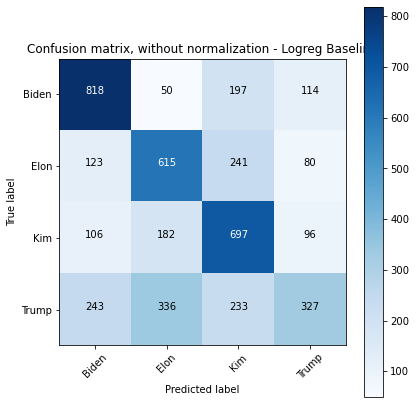

In [62]:
cnf_matrix_logreg_baseline = confusion_matrix(y_test, y_pred_logreg_baseline)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_logreg_baseline, classes=['Biden', 'Elon', 'Kim', 'Trump'],
                      title='Confusion matrix, without normalization - Logreg Baseline')

The logistic regression on the basic features gives an encouraging result. Indeed the accuracy is 55% meaning that the model with the basic functions is capturing half of the time the correct results (each class has a probability of 25% to be identified). 

This is already a good result, but it can be improved further using the topic modelling developed so far. 

### 3.1.2. Truncated Tf-idf vector

In this section I am applying Logistic Regression to the Tf-idf vectorization of my text, but in its reduced form (truncated SVD) with 400 vectors. 

In [63]:
# printing the shape of the Tf-idf vector for a reference
print(X_trval_svd.shape, X_test_svd.shape)

(17768, 400) (4458, 400)


In [64]:
# Fitting the Logistic Regression 
logreg_estimator = Pipeline([
                            ('scaler', StandardScaler()), 
                            ('logreg', LogisticRegression(random_state = 0))
                            ])

C = np.logspace(-4, 10, 30)
penalty = ['l1', 'l2']

parameters = dict(logreg__C = C,
                  logreg__penalty = penalty)

# Fitting the Logistic Regression 
logreg_svd = GridSearchCV(
                        logreg_estimator, 
                        parameters, 
                        cv = 5, 
                        refit = True, 
                        return_train_score = True,
                        verbose = 1,
                        n_jobs= 1)

logreg_svd.fit(X_trval_svd, y_trval)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(random_state=0))]),
             n_jobs=1,
             param_grid={'logreg__C': array([1.00e-04, 3.04e-04, 9.24e-04, 2.81e-03, 8.53e-03, 2.59e-02,
       7.88e-02, 2.40e-01, 7.28e-01, 2.21e+00, 6.72e+00, 2.04e+01,
       6.21e+01, 1.89e+02, 5.74e+02, 1.74e+03, 5.30e+03, 1.61e+04,
       4.89e+04, 1.49e+05, 4.52e+05, 1.37e+06, 4.18e+06, 1.27e+07,
       3.86e+07, 1.17e+08, 3.56e+08, 1.08e+09, 3.29e+09, 1.00e+10]),
                         'logreg__penalty': ['l1', 'l2']},
             return_train_score=True, verbose=1)

In [65]:
# best logreg estimator
best_logreg_svd = logreg_svd.best_estimator_

# fitting the best estimator again 
best_logreg_svd.fit(X_trval_svd, y_trval)

# reporting validation score
print('Test accuracy Logreg SVD: {:.2f}%'.format(100*best_logreg_svd.score(X_test_svd, y_test)))

Test accuracy Logreg SVD: 71.24%


In [66]:
#Predict values based on new parameters
y_pred_logreg_svd = best_logreg_svd.predict(X_test_svd)

In [67]:
print(classification_report(y_test, y_pred_logreg_svd))

              precision    recall  f1-score   support

       biden       0.81      0.77      0.79      1179
        elon       0.66      0.73      0.69      1059
         kim       0.71      0.74      0.73      1081
       trump       0.67      0.61      0.64      1139

    accuracy                           0.71      4458
   macro avg       0.71      0.71      0.71      4458
weighted avg       0.71      0.71      0.71      4458



Confusion matrix, without normalization
[[906  77  67 129]
 [ 45 776 120 118]
 [ 43 147 800  91]
 [129 180 136 694]]


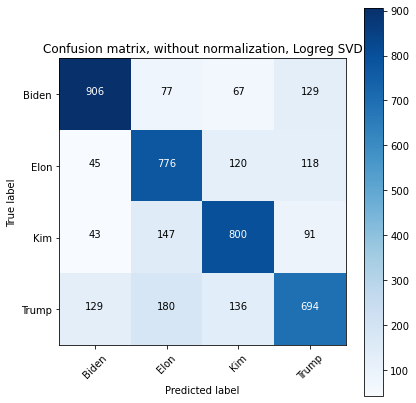

In [68]:
cnf_matrix_logreg_svd = confusion_matrix(y_test, y_pred_logreg_svd)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_logreg_svd, classes=['Biden', 'Elon', 'Kim', 'Trump'],
                      title='Confusion matrix, without normalization, Logreg SVD')

We can see that there is an enormous improvement in the model! We have now an accuracy of 71%, which is amazing! Both Precision and Recall are also quite good.

If we look at the Confusion Matrix we can see that for Biden, Elon and Kim there is not much confusion, whereas for Trump we can see that the model is predicting different labels (being Elon the most probable). 

Let's see if by using the reduced Tf-idf vector and the basic features we can improve this encouraging result!

### 3.1.3. Truncated Tf-idf vector + Basic Features

In this model I am assessing the performance of the Logistic Regression on the Tf-idf reduced vector (Truncated SVD - 400 components) *and* the basic features (likes, retweets, hasthags etc).

In [69]:
# creating a copy of the train-test dataframes
X_trval_svd_full = X_trval_svd.copy()
X_test_svd_full = X_test_svd.copy()

In [70]:
# priting the shape of the tf-idf vector for a reference
print(X_trval_svd_full.shape, X_test_svd_full.shape)

(17768, 400) (4458, 400)


In [71]:
# transforming the variables into arrays
likes_trval = X_trval[['likes']].to_numpy()
retweets_trval = X_trval[['retweets']].to_numpy()
total_words_trval = X_trval[['total_words']].to_numpy()
num_hashtags_trval = X_trval[['num_hashtags']].to_numpy()
num_mentions_trval = X_trval[['num_mentions']].to_numpy()
num_emojis_trval = X_trval[['num_emojis']].to_numpy()
num_upper_words_trval = X_trval[['num_upper_words']].to_numpy()
sentiment_trval = X_trval[['sentiment']].to_numpy()

likes_test = X_test[['likes']].to_numpy()
retweets_test = X_test[['retweets']].to_numpy()
total_words_test = X_test[['total_words']].to_numpy()
num_hashtags_test = X_test[['num_hashtags']].to_numpy()
num_mentions_test = X_test[['num_mentions']].to_numpy()
num_emojis_test = X_test[['num_emojis']].to_numpy()
num_upper_words_test = X_test[['num_upper_words']].to_numpy()
sentiment_test = X_test[['sentiment']].to_numpy()

In [72]:
# creating the vector matrix which includes the basic features (likes, retweets, hashtags etc)
X_trval_svd_full = np.hstack((X_trval_svd_full, likes_trval))
X_trval_svd_full = np.hstack((X_trval_svd_full, retweets_trval))
X_trval_svd_full = np.hstack((X_trval_svd_full, total_words_trval))
X_trval_svd_full = np.hstack((X_trval_svd_full, num_hashtags_trval))
X_trval_svd_full = np.hstack((X_trval_svd_full, num_mentions_trval))
X_trval_svd_full = np.hstack((X_trval_svd_full, num_emojis_trval))
X_trval_svd_full = np.hstack((X_trval_svd_full, num_upper_words_trval))
X_trval_svd_full = np.hstack((X_trval_svd_full, sentiment_trval))

X_test_svd_full = np.hstack((X_test_svd_full, likes_test))
X_test_svd_full = np.hstack((X_test_svd_full, retweets_test))
X_test_svd_full = np.hstack((X_test_svd_full, total_words_test))
X_test_svd_full = np.hstack((X_test_svd_full, num_hashtags_test))
X_test_svd_full = np.hstack((X_test_svd_full, num_mentions_test))
X_test_svd_full = np.hstack((X_test_svd_full, num_emojis_test))
X_test_svd_full = np.hstack((X_test_svd_full, num_upper_words_test))
X_test_svd_full = np.hstack((X_test_svd_full, sentiment_test))

print(X_trval_svd_full.shape, X_test_svd_full.shape)

(17768, 408) (4458, 408)


In [73]:
# Fitting the Logistic Regression 
logreg_estimator = Pipeline([
                            ('scaler', StandardScaler()), 
                            ('logreg', LogisticRegression(random_state = 0))
                            ])

C = np.logspace(-4, 10, 30)
penalty = ['l1', 'l2']

parameters = dict(logreg__C = C,
                  logreg__penalty = penalty)

logreg_svd_full = GridSearchCV(
                        logreg_estimator, 
                        parameters, 
                        cv = 5, 
                        refit = True, 
                        return_train_score = True,
                        verbose = 1,
                        n_jobs= 1)

logreg_svd_full.fit(X_trval_svd_full, y_trval)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(random_state=0))]),
             n_jobs=1,
             param_grid={'logreg__C': array([1.00e-04, 3.04e-04, 9.24e-04, 2.81e-03, 8.53e-03, 2.59e-02,
       7.88e-02, 2.40e-01, 7.28e-01, 2.21e+00, 6.72e+00, 2.04e+01,
       6.21e+01, 1.89e+02, 5.74e+02, 1.74e+03, 5.30e+03, 1.61e+04,
       4.89e+04, 1.49e+05, 4.52e+05, 1.37e+06, 4.18e+06, 1.27e+07,
       3.86e+07, 1.17e+08, 3.56e+08, 1.08e+09, 3.29e+09, 1.00e+10]),
                         'logreg__penalty': ['l1', 'l2']},
             return_train_score=True, verbose=1)

In [74]:
# best logreg estimator
best_logreg_svd_full = logreg_svd_full.best_estimator_

# fitting the best estimator again 
best_logreg_svd_full.fit(X_trval_svd_full, y_trval)

# reporting validation score
print('Test accuracy Logreg SVD Full: {:.2f}%'.format(100*best_logreg_svd_full.score(X_test_svd_full, y_test)))

Test accuracy Logreg SVD Full: 76.42%


In [75]:
#Predict values based on new parameters
y_pred_logreg_svd_full = best_logreg_svd_full.predict(X_test_svd_full)

In [76]:
print(classification_report(y_test, y_pred_logreg_svd_full))

              precision    recall  f1-score   support

       biden       0.84      0.82      0.83      1179
        elon       0.75      0.77      0.76      1059
         kim       0.74      0.80      0.77      1081
       trump       0.72      0.66      0.69      1139

    accuracy                           0.76      4458
   macro avg       0.76      0.76      0.76      4458
weighted avg       0.76      0.76      0.76      4458



Confusion matrix, without normalization
[[972  27  77 103]
 [ 21 819 115 104]
 [ 43  91 866  81]
 [118 153 118 750]]


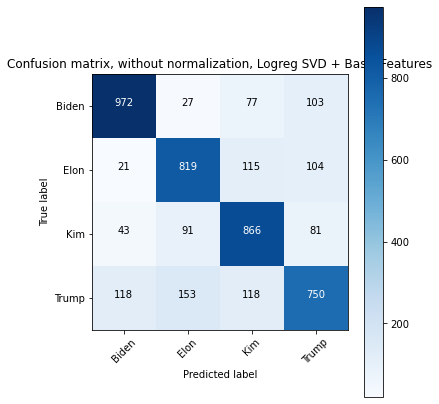

In [77]:
cnf_matrix_logreg_svd_full = confusion_matrix(y_test, y_pred_logreg_svd_full)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_logreg_svd_full, classes=['Biden', 'Elon', 'Kim', 'Trump'],
                      title='Confusion matrix, without normalization, Logreg SVD + Basic Features')

Yes! The logistic regression done on the reduced Tf-idf vector with the basic features gives a 76% accuracy score with very good results as well in terms of Precision and Recall. 

The Confusion Matrix for Trump has improved as well (we moved from 690 true positive to 750 true positives). 

I will now investigate the LDA features if they are somehow better than this approach.

### 3.1.4. LDA on Tf-idf Vector

In [78]:
# Fitting the Logistic Regression 
logreg_estimator = Pipeline([
                            ('scaler', StandardScaler()), 
                            ('logreg', LogisticRegression(random_state = 0))
                            ])

C = np.logspace(-4, 10, 30)
penalty = ['l1', 'l2']

parameters = dict(logreg__C = C,
                  logreg__penalty = penalty)

logreg_lda = GridSearchCV(
                        logreg_estimator, 
                        parameters, 
                        cv = 5, 
                        refit = True, 
                        return_train_score = True,
                        verbose = 1,
                        n_jobs= 1)

logreg_lda.fit(X_trval_lda, y_trval)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   18.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(random_state=0))]),
             n_jobs=1,
             param_grid={'logreg__C': array([1.00e-04, 3.04e-04, 9.24e-04, 2.81e-03, 8.53e-03, 2.59e-02,
       7.88e-02, 2.40e-01, 7.28e-01, 2.21e+00, 6.72e+00, 2.04e+01,
       6.21e+01, 1.89e+02, 5.74e+02, 1.74e+03, 5.30e+03, 1.61e+04,
       4.89e+04, 1.49e+05, 4.52e+05, 1.37e+06, 4.18e+06, 1.27e+07,
       3.86e+07, 1.17e+08, 3.56e+08, 1.08e+09, 3.29e+09, 1.00e+10]),
                         'logreg__penalty': ['l1', 'l2']},
             return_train_score=True, verbose=1)

In [79]:
# best logreg estimator
best_logreg_lda = logreg_lda.best_estimator_

# fitting the best estimator again 
best_logreg_lda.fit(X_trval_lda, y_trval)

# reporting validation score
print('Test accuracy Logreg LDA: {:.2f}%'.format(100*best_logreg_lda.score(X_test_lda, y_test)))

Test accuracy Logreg LDA: 43.61%


In [80]:
#Predict values based on new parameters
y_pred_logreg_lda = best_logreg_lda.predict(X_test_lda)

In [81]:
print(classification_report(y_test, y_pred_logreg_lda))

              precision    recall  f1-score   support

       biden       0.46      0.82      0.59      1179
        elon       0.52      0.25      0.34      1059
         kim       0.51      0.41      0.46      1081
       trump       0.27      0.23      0.25      1139

    accuracy                           0.44      4458
   macro avg       0.44      0.43      0.41      4458
weighted avg       0.44      0.44      0.41      4458



Confusion matrix, without normalization
[[970  25  45 139]
 [321 265 213 260]
 [202 133 448 298]
 [613  86 179 261]]


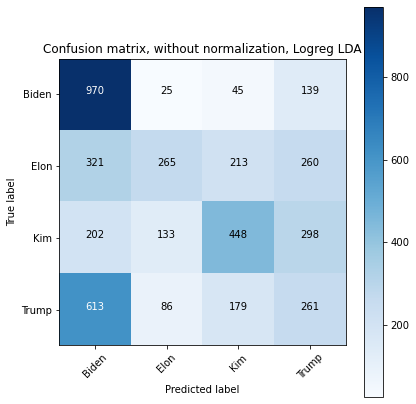

In [82]:
cnf_matrix_logreg_lda = confusion_matrix(y_test, y_pred_logreg_lda)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_logreg_lda, classes=['Biden', 'Elon', 'Kim', 'Trump'],
                      title='Confusion matrix, without normalization, Logreg LDA')

We had a hint that LDA was not performing well when some additional EDA was done on the topics modelled and we have our results now! The LDA on tf-idf is definitely not a good idea!

The results are over performing the simplest model (baseline model with basic features, with accuracy of 55%). I am pretty sure that by testing LDA directly run on Tokens won't change this result. Let's try it now. 

### 3.1.5 LDA on Tokens

In [83]:
# printing the matrix for reference
X_trval_lda_full_matrix

array([[0.27, 0.01, 0.63, ..., 0.01, 0.01, 0.01],
       [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       [0.01, 0.01, 0.01, ..., 0.5 , 0.01, 0.01],
       ...,
       [0.03, 0.35, 0.03, ..., 0.03, 0.39, 0.03],
       [0.03, 0.03, 0.03, ..., 0.22, 0.03, 0.03],
       [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05]])

In [84]:
# Fitting the Logistic Regression 
logreg_estimator = Pipeline([
                            ('scaler', StandardScaler()), 
                            ('logreg', LogisticRegression(random_state = 0))
                            ])

C = np.logspace(-4, 10, 30)
penalty = ['l1', 'l2']

parameters = dict(logreg__C = C,
                  logreg__penalty = penalty)

logreg_lda_full = GridSearchCV(
                        logreg_estimator, 
                        parameters, 
                        cv = 5, 
                        refit = True, 
                        return_train_score = True,
                        verbose = 1,
                        n_jobs= 1)

logreg_lda_full.fit(X_trval_lda_full_matrix, y_trval)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   26.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(random_state=0))]),
             n_jobs=1,
             param_grid={'logreg__C': array([1.00e-04, 3.04e-04, 9.24e-04, 2.81e-03, 8.53e-03, 2.59e-02,
       7.88e-02, 2.40e-01, 7.28e-01, 2.21e+00, 6.72e+00, 2.04e+01,
       6.21e+01, 1.89e+02, 5.74e+02, 1.74e+03, 5.30e+03, 1.61e+04,
       4.89e+04, 1.49e+05, 4.52e+05, 1.37e+06, 4.18e+06, 1.27e+07,
       3.86e+07, 1.17e+08, 3.56e+08, 1.08e+09, 3.29e+09, 1.00e+10]),
                         'logreg__penalty': ['l1', 'l2']},
             return_train_score=True, verbose=1)

In [85]:
# best logreg estimator
best_logreg_lda_full = logreg_lda_full.best_estimator_

# fitting the best estimator again 
best_logreg_lda_full.fit(X_trval_lda_full_matrix, y_trval)

# reporting validation score
print('Test accuracy Logreg LDA: {:.2f}%'.format(100*best_logreg_lda_full.score(X_test_lda_full_matrix, y_test)))

Test accuracy Logreg LDA: 45.20%


In [86]:
#Predict values based on new parameters
y_pred_logreg_lda_full = best_logreg_lda_full.predict(X_test_lda_full_matrix)

In [87]:
print(classification_report(y_test, y_pred_logreg_lda_full))

              precision    recall  f1-score   support

       biden       0.55      0.63      0.59      1179
        elon       0.43      0.42      0.42      1059
         kim       0.43      0.51      0.47      1081
       trump       0.36      0.24      0.29      1139

    accuracy                           0.45      4458
   macro avg       0.44      0.45      0.44      4458
weighted avg       0.44      0.45      0.44      4458



We have very similar results with the former LDA on the reduced Tf-idf vector. 
For sake of completeness I am also going to test LDA features with Random Forests to see if there is any improvement in accuracy. 

## 3.2 Random Forest

In this section I am buding different classifiers with Random Forest. 
As I have done for the Logistic Regression, I am taking into consideration different types of input variables/features, as follows: 

3.1.1. Basic Features
***
3.1.2. Truncated Tf-idf Vector
***
3.1.3. Truncated Tf-idf Vector + Basic Features
***
3.1.4. LDA on Tf-idf Vector
*** 
3.1.5. LDA on Tokens 

### 3.2.1 Basic Features

In [88]:
# Fitting the Random Forest Classifier 
forest = RandomForestClassifier(random_state = 1)

# Creating lists of parameter for Random Forest Classifier 
n_estimators = [100, 200, 300]
max_depth = [4,6,8] 
criterion = ['gini', 'entropy']

# Creating  dictionary of all the parameter options 
parameters = dict(n_estimators = n_estimators, 
                  max_depth = max_depth,
                  criterion = criterion
                  )

# Creating a grid search object
forest_baseline = GridSearchCV(forest, 
                      parameters, 
                      cv = 5,
                      refit=True,
                      verbose = 1,
                      n_jobs= 1)

# Fitting the grid search
forest_baseline.fit(X_trval_baseline, y_trval)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.1min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [89]:
best_forest_baseline = forest_baseline.best_estimator_

best_forest_baseline.fit(X_trval_baseline, y_trval)

# Report validation score
print('Test accuracy Random Forest Baseline: {:.2f}%'.format(100*best_forest_baseline.score(X_test_baseline, y_test)))

Test accuracy Random Forest Baseline: 69.11%


In [90]:
#Predict values based on new parameters
y_pred_forest_baseline = best_forest_baseline.predict(X_test_baseline)

In [91]:
print(classification_report(y_test, y_pred_forest_baseline))

              precision    recall  f1-score   support

       biden       0.76      0.70      0.73      1179
        elon       0.75      0.71      0.73      1059
         kim       0.58      0.72      0.64      1081
       trump       0.70      0.64      0.67      1139

    accuracy                           0.69      4458
   macro avg       0.70      0.69      0.69      4458
weighted avg       0.70      0.69      0.69      4458



Confusion matrix, without normalization
[[831  51 162 135]
 [104 747 145  63]
 [ 57 134 774 116]
 [ 97  68 245 729]]


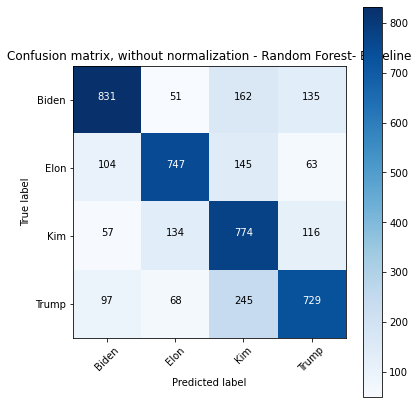

In [92]:
cnf_matrix_rf_baseline = confusion_matrix(y_test, y_pred_forest_baseline)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_rf_baseline, classes=['Biden', 'Elon', 'Kim', 'Trump'],
                      title='Confusion matrix, without normalization - Random Forest- Baseline')

The Random Forest on the basic features does the job! Absolutely stunning result: 69% accuracy! 

If we look at the confusion matrix we can see that the result is quite impressive!

### 3.2.2. Truncated Tf-idf Vector

In [93]:
# Fitting the Random Forest Classifier 
forest = RandomForestClassifier(random_state = 1)

# Creating lists of parameter for Random Forest Classifier 
n_estimators = [100, 200, 300]
max_depth = [4,6,8] 
criterion = ['gini', 'entropy']

# Creating  dictionary of all the parameter options 
parameters = dict(n_estimators = n_estimators, 
                  max_depth = max_depth,
                  criterion = criterion
                  )

forest_svd = GridSearchCV(forest, 
                      parameters, 
                      cv = 5,
                      refit=True,
                      verbose = 1,
                      n_jobs= 1)

# Fitting the grid search
forest_svd.fit(X_trval_svd, y_trval)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 41.1min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [94]:
best_forest_svd = forest_svd.best_estimator_

best_forest_svd.fit(X_trval_svd, y_trval)

# Report validation score
print('Test accuracy Random Forest SVD: {:.2f}%'.format(100*best_forest_svd.score(X_test_svd, y_test)))

Test accuracy Random Forest SVD: 61.64%


In [95]:
#Predict values based on new parameters
y_pred_forest_svd = best_forest_svd.predict(X_test_svd)

In [96]:
print(classification_report(y_test, y_pred_forest_svd))

              precision    recall  f1-score   support

       biden       0.63      0.81      0.71      1179
        elon       0.57      0.61      0.59      1059
         kim       0.64      0.63      0.64      1081
       trump       0.61      0.41      0.49      1139

    accuracy                           0.62      4458
   macro avg       0.62      0.61      0.61      4458
weighted avg       0.62      0.62      0.61      4458



Confusion matrix, without normalization
[[954  82  66  77]
 [121 648 163 127]
 [141 168 682  90]
 [290 237 148 464]]


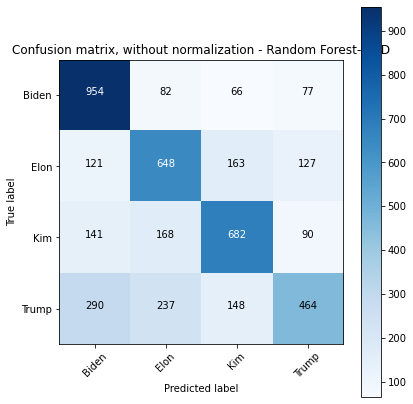

In [97]:
cnf_matrix_forest_svd = confusion_matrix(y_test, y_pred_forest_svd)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_forest_svd, classes=['Biden', 'Elon', 'Kim', 'Trump'],
                      title='Confusion matrix, without normalization - Random Forest- SVD')

The Random Forest on the truncated Tf-idf vector is not improving the Random Forest baseline, on the contrary it is lower!
Let's try, as done for the Logistic Regression, other combinations of features. 

### 3.2.3. Truncated Tf-idf Vector + Basic Features


In [98]:
# Fitting the Random Forest Classifier 
forest = RandomForestClassifier(random_state = 1)

# Creating lists of parameter for Random Forest Classifier 
n_estimators = [100, 200, 300]
max_depth = [4,6,8] 
criterion = ['gini', 'entropy']

# Creating  dictionary of all the parameter options 
parameters = dict(n_estimators = n_estimators, 
                  max_depth = max_depth,
                  criterion = criterion
                  )

# Creating a grid search object
forest_svd_full = GridSearchCV(forest, 
                      parameters, 
                      cv = 5,
                      refit=True,
                      verbose = 1,
                      n_jobs= 1)

# Fitting the grid search
forest_svd_full.fit(X_trval_svd_full, y_trval)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 40.2min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [99]:
best_forest_svd_full = forest_svd_full.best_estimator_

best_forest_svd_full.fit(X_trval_svd_full, y_trval)

# Report validation score
print('Test accuracy Random Forest SVD: {:.2f}%'.format(100*best_forest_svd_full.score(X_test_svd_full, y_test)))

Test accuracy Random Forest SVD: 69.52%


In [100]:
#Predict values based on new parameters
y_pred_forest_svd_full = best_forest_svd_full.predict(X_test_svd_full)

In [101]:
print(classification_report(y_test, y_pred_forest_svd_full))

              precision    recall  f1-score   support

       biden       0.72      0.82      0.76      1179
        elon       0.71      0.71      0.71      1059
         kim       0.67      0.73      0.70      1081
       trump       0.68      0.52      0.59      1139

    accuracy                           0.70      4458
   macro avg       0.69      0.69      0.69      4458
weighted avg       0.69      0.70      0.69      4458



Confusion matrix, without normalization
[[963  49  80  87]
 [ 87 755 114 103]
 [ 86 112 787  96]
 [205 141 199 594]]


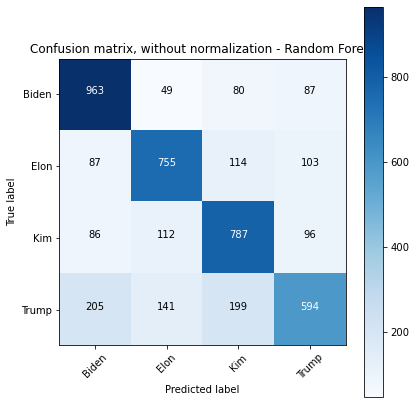

In [102]:
cnf_matrix_forest_svd_full = confusion_matrix(y_test, y_pred_forest_svd_full)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_forest_svd_full, classes=['Biden', 'Elon', 'Kim', 'Trump'],
                      title='Confusion matrix, without normalization - Random Forest')

Much better results! We achieved 70%, outperforming for 1% the baseline model. The confusion matrix though doesn't look amazing with Trump being identified correctly only 594 times (in absolute values).


I will nevertheless test LDA even though I am conscious is not going to give any improvements to my models.

### 3.2.4. LDA on Tf-idf Vector

In [103]:
# Fitting the Random Forest Classifier 
forest = RandomForestClassifier(random_state = 1)

# Creating lists of parameter for Random Forest Classifier 
n_estimators = [100, 200, 300]
max_depth = [4,6,8] 
criterion = ['gini', 'entropy']

# Creating  dictionary of all the parameter options 
parameters = dict(n_estimators = n_estimators, 
                  max_depth = max_depth,
                  criterion = criterion
                  )

# Creating a grid search object
forest_lda = GridSearchCV(forest, 
                      parameters, 
                      cv = 5,
                      refit=True,
                      verbose = 1,
                      n_jobs= 1)

# Fitting the grid search
forest_lda.fit(X_trval_lda, y_trval)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  4.3min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [104]:
best_forest_lda = forest_lda.best_estimator_

best_forest_lda.fit(X_trval_lda, y_trval)

# Report validation score
print('Test accuracy Random Forest LDA: {:.2f}%'.format(100*best_forest_lda.score(X_test_lda, y_test)))

Test accuracy Random Forest LDA: 48.52%


In [105]:
#Predict values based on new parameters
y_pred_forest_lda= best_forest_lda.predict(X_test_lda)

In [106]:
print(classification_report(y_test, y_pred_forest_lda))

              precision    recall  f1-score   support

       biden       0.56      0.69      0.62      1179
        elon       0.47      0.36      0.41      1059
         kim       0.48      0.57      0.52      1081
       trump       0.39      0.31      0.34      1139

    accuracy                           0.49      4458
   macro avg       0.47      0.48      0.47      4458
weighted avg       0.48      0.49      0.47      4458



Confusion matrix, without normalization
[[808  83  84 204]
 [200 382 303 174]
 [ 79 197 619 186]
 [352 146 287 354]]


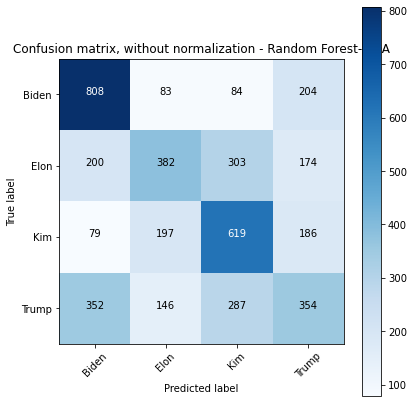

In [107]:
cnf_matrix_forest_lda = confusion_matrix(y_test, y_pred_forest_lda)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_forest_lda, classes=['Biden', 'Elon', 'Kim', 'Trump'],
                      title='Confusion matrix, without normalization - Random Forest- LDA')

### 3.2.5. LDA on Tokens 

In [108]:
# Fitting the Random Forest Classifier 
forest = RandomForestClassifier(random_state = 1)

# Creating lists of parameter for Random Forest Classifier 
n_estimators = [100, 200, 300]
max_depth = [4,6,8] 
criterion = ['gini', 'entropy']

# Creating  dictionary of all the parameter options 
parameters = dict(n_estimators = n_estimators, 
                  max_depth = max_depth,
                  criterion = criterion
                  )

# Creating a grid search object
forest_lda_full = GridSearchCV(forest, 
                      parameters, 
                      cv = 5,
                      refit=True,
                      verbose = 1,
                      n_jobs= 1)

# Fitting the grid search
forest_lda_full.fit(X_trval_lda_full_matrix, y_trval)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  4.8min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [109]:
best_forest_lda_full = forest_lda_full.best_estimator_

best_forest_lda_full.fit(X_trval_lda_full_matrix, y_trval)

# Report validation score
print('Test accuracy Random Forest LDA: {:.2f}%'.format(100*best_forest_lda_full.score(X_test_lda_full_matrix, y_test)))

Test accuracy Random Forest LDA: 48.47%


In [110]:
#Predict values based on new parameters
y_pred_forest_lda_full = best_forest_lda_full.predict(X_test_lda_full_matrix)

In [111]:
print(classification_report(y_test, y_pred_forest_lda_full))

              precision    recall  f1-score   support

       biden       0.61      0.63      0.62      1179
        elon       0.46      0.36      0.41      1059
         kim       0.44      0.60      0.51      1081
       trump       0.41      0.33      0.37      1139

    accuracy                           0.48      4458
   macro avg       0.48      0.48      0.48      4458
weighted avg       0.48      0.48      0.48      4458



Confusion matrix, without normalization
[[748  85 169 177]
 [137 383 341 198]
 [ 89 166 652 174]
 [247 197 317 378]]


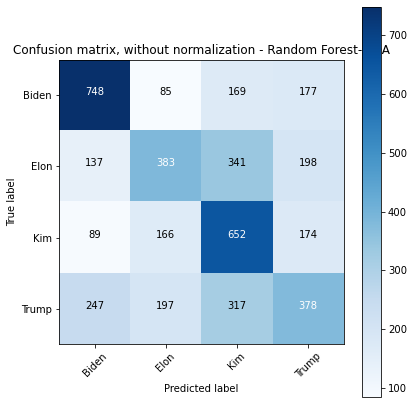

In [112]:
cnf_matrix_forest_lda_full = confusion_matrix(y_test, y_pred_forest_lda_full)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix_forest_lda_full, classes=['Biden', 'Elon', 'Kim', 'Trump'],
                      title='Confusion matrix, without normalization - Random Forest- LDA')

Very low results for the LDA with the 2 different features (tf-idf reduced vector and the tokens).

## 3. Dense Network

Having seen that the **Truncated Tf-idf Vector + Basic Features** features are the ones which are best performing across Logistic Regression and Random Forest, I will be testing them for a Dense Network and I will build 2 models:

***
3.1. 2 layers Dense Network
***
3.2. 3 layers Dense Network

In reality I am not very familiar with Dense networks and the idea of building different layers is quite intriguing but also very *very* challenging (which hyperparameters to tune?). I will test somehow 2 layers and 3 layers to see if there are any differences. 

### 3.1. 2-Layers dense Network

In [113]:
# copying the dataframes for reference
X_trval_keras = X_trval_svd_full.copy()
X_test_keras = X_test_svd_full.copy()

In [114]:
# priting shape of the vectors
print(X_trval_svd_full.shape, X_test_svd_full.shape)

(17768, 408) (4458, 408)


In [115]:
# converting Y string labels into numericals
y_trval_keras = y_trval.map({'biden': 0, 'trump': 1, 'kim': 2, 'elon':3})
y_test_keras = y_test.map({'biden': 0, 'trump': 1, 'kim': 2, 'elon':3})

In [116]:
os.environ['PYTHONHASHSEED']= '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

np.random.seed(36)
rn.seed(1255)

# implement a fully-connected (dense) neural network 
model = Sequential()

# Hidden layer
model.add(Dense(
    units = 128, 
    activation = activations.relu,
    input_dim = 408,
    kernel_regularizer=tf.keras.regularizers.l2(0.001), 
    kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)
    ))

# Dropout Layer
model.add(Dropout(0.5))

# Hidden layer
model.add(Dense(
    units = 64, 
    activation = activations.relu,
    kernel_regularizer=tf.keras.regularizers.l2(0.001), 
    kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)
    ))

# Dropout Layer
model.add(Dropout(0.5))

# Hidden layer
model.add(Dense(
    units = 4, 
    activation=activations.softmax,
    kernel_regularizer=tf.keras.regularizers.l2(0.001),
    kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0)
    ))

model.summary()

# Loss function and training operation
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['acc'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               52352     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 60,868
Trainable params: 60,868
Non-trainable params: 0
_________________________________________________________________


In [117]:
# End training when accuracy stops improving (optional)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=6) #stop training after patience/epochs not improving

In [118]:
# Rescale train and validation data
scaler = StandardScaler()

X_trval_keras_preprocessed = scaler.fit_transform(X_trval_keras)
X_test_keras_preprocessed = scaler.transform(X_test_keras)

print('Train-Test size of data:', X_trval_keras_preprocessed.shape)

Train-Test size of data: (17768, 408)


In [119]:
# Fit model
history = model.fit(
                    x = X_trval_keras_preprocessed, 
                    y = y_trval_keras, 
                    validation_split = 0.2, 
                    batch_size = 50, 
                    epochs = 100,
                    shuffle = False, 
                    callbacks = [early_stopping] 
                    )


loss, accuracy = model.evaluate(X_trval_keras_preprocessed, y_trval_keras, verbose=False)
print("Keras Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test_keras_preprocessed, y_test_keras, verbose=False)
print("Keras Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
285/285 [==============================] - 0s 1ms/step - loss: 1.8450 - acc: 0.3459 - val_loss: 1.5035 - val_acc: 0.6134
Epoch 2/100
285/285 [==============================] - 0s 1ms/step - loss: 1.4173 - acc: 0.5340 - val_loss: 1.1374 - val_acc: 0.7079
Epoch 3/100
285/285 [==============================] - 0s 1ms/step - loss: 1.1731 - acc: 0.6485 - val_loss: 0.9897 - val_acc: 0.7324
Epoch 4/100
285/285 [==============================] - 0s 1ms/step - loss: 1.0569 - acc: 0.6968 - val_loss: 0.9217 - val_acc: 0.7442
Epoch 5/100
285/285 [==============================] - 0s 1ms/step - loss: 0.9631 - acc: 0.7264 - val_loss: 0.8903 - val_acc: 0.7454
Epoch 6/100
285/285 [==============================] - 0s 1ms/step - loss: 0.9033 - acc: 0.7406 - val_loss: 0.8518 - val_acc: 0.7538
Epoch 7/100
285/285 [==============================] - 0s 1ms/step - loss: 0.8697 - acc: 0.7473 - val_loss: 0.8284 - val_acc: 0.7577
Epoch 8/100
285/285 [==============================] - 0s 1ms/step - 

In [120]:
test_preds = model.predict_classes(X_test_keras_preprocessed, verbose = 1)
print('Predictions:', test_preds.shape)

140/140 [==============================] - 0s 408us/step
Predictions: (4458,)


In [121]:
# checking the predictions and if I have all the classes:
np.unique(test_preds, return_counts=True)

(array([0, 1, 2, 3]), array([1198, 1038, 1150, 1072]))

In [122]:
print(classification_report(y_test_keras, test_preds))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1179
           1       0.72      0.65      0.68      1139
           2       0.75      0.79      0.77      1081
           3       0.75      0.76      0.76      1059

    accuracy                           0.76      4458
   macro avg       0.76      0.76      0.76      4458
weighted avg       0.76      0.76      0.76      4458



Results are at parity with the Logistic Regression and the Random Forest, both on Tf-idf + basic features. 
This means that there are no non-linear relations between the variables, mainly due to the tf-idf vectorization. 

## 3.2 3-Layers Dense Network

I am trying over here to add some additional layers. 
For sake of simplicity of this notebook I am not running all the layers, I will just add the 3rd layer. 

In [123]:
# implement a fully-connected (dense) neural network 
model2 = Sequential()

# Hidden layer 1
model2.add(Dense(
    units = 128, 
    activation = activations.relu,
    input_dim = 408,
    kernel_regularizer=tf.keras.regularizers.l2(0.001), 
    kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)
    ))

# Dropout Layer 
model2.add(Dropout(0.5))

# Hidden layer 2
model2.add(Dense(
    units = 64, 
    activation = activations.relu,
    kernel_regularizer=tf.keras.regularizers.l2(0.001), 
    kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)
    ))

# Dropout Layer 
model2.add(Dropout(0.5))

# Hidden layer 3
model2.add(Dense(
    units = 64, 
    activation = activations.relu,
    kernel_regularizer=tf.keras.regularizers.l2(0.001), 
    kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)
    ))

# Dropout Layer 
model2.add(Dropout(0.5))

# Hidden layer
model2.add(Dense(
    units = 4, 
    activation=activations.softmax,
    kernel_regularizer=tf.keras.regularizers.l2(0.001),
    kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0)
    ))

model2.summary()

# Loss function and training operation
model2.compile(
    optimizer = keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               52352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                

In [124]:
# Fit model
history = model2.fit(
                    x = X_trval_keras_preprocessed, 
                    y = y_trval_keras, 
                    validation_split = 0.2, 
                    batch_size = 50, 
                    epochs = 100,
                    shuffle = False, 
                    callbacks = [early_stopping] 
                    )


loss, accuracy = model2.evaluate(X_trval_keras_preprocessed, y_trval_keras, verbose=False)
print("Keras Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(X_test_keras_preprocessed, y_test_keras, verbose=False)
print("Keras Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
285/285 [==============================] - 0s 2ms/step - loss: 2.1292 - acc: 0.2678 - val_loss: 1.8248 - val_acc: 0.3768
Epoch 2/100
285/285 [==============================] - 0s 1ms/step - loss: 1.7888 - acc: 0.3367 - val_loss: 1.6542 - val_acc: 0.5256
Epoch 3/100
285/285 [==============================] - 0s 1ms/step - loss: 1.5716 - acc: 0.4551 - val_loss: 1.3515 - val_acc: 0.6117
Epoch 4/100
285/285 [==============================] - 0s 1ms/step - loss: 1.3605 - acc: 0.5632 - val_loss: 1.1560 - val_acc: 0.6854
Epoch 5/100
285/285 [==============================] - 0s 1ms/step - loss: 1.2131 - acc: 0.6390 - val_loss: 1.0257 - val_acc: 0.7240
Epoch 6/100
285/285 [==============================] - 0s 1ms/step - loss: 1.1072 - acc: 0.6807 - val_loss: 0.9573 - val_acc: 0.7364
Epoch 7/100
285/285 [==============================] - 0s 1ms/step - loss: 1.0187 - acc: 0.7155 - val_loss: 0.9084 - val_acc: 0.7462
Epoch 8/100
285/285 [==============================] - 0s 1ms/step - 

The 3 Layers model vs the 2 Layers Model is not increasing  the Accuracy over the Test set (0.76 vs 0.76). 
As mentioned, I am not going to deep dive further in this unexplored domain, I will keep the results as they are given that they are quite satisfying!

In the next paragraph I will be exploring some Auto Machine Learning libraries to see if I can automatically tune the hyperparameters of my models and see if I can perform better!

# 4. Auto ML

In this section I am going to try an Automatic Machine Learning library called TPOT which stands for a Tree-based Pipeline Optimization Tool.

TPOT uses a tree-based structure to represent a model pipeline for a predictive modeling problem, including data preparation and modeling algorithms and model hyperparameters. 

I am goint to try TPOT with 3 different approaches: 

***
4.1. **Truncated SVD Tfidf Vector + Basic Features** - this was the best performing model I have run so far (accuracy 76% in Logreg) - I am wondering is there anything else I could do to improve this already good result? Are there any other hyperparameters to tune to increase accuracy? 

***
4.2. **Full Tfidf vector** - so far I haven't tested the Tf-idf vector (sparse matrix) with any model as I thought it would have been too complex to handle - is TPOT going to make my life easier?

***
4.3. **LDA Topics** - this approach turned out to be the worse one when dealing with topic modelling, for the nature of the tweets per se. Is there any way the accuracy can be increased? Maybe by using a different model?

***
4.4. **Raw text** - I will be using the Auto Keras auto Machine Learning approach on raw text to try to identify the best Dense Network - Auto Keras should be able to perform selection and tuning of hyper parameters on its own (which is a very difficult task!) 


## 4.1. Truncated Tf-idf Vector + Basic Features

In [125]:
# function to run Tpot Auto ML

def get_tpot_model(X, y, 
                   filename_variant='', 
                   verbosity=2, 
                   generations=5,
                   population_size=10, 
                   n_jobs=1, 
                   scoring='accuracy'):
    """
    Generates an Automatic ML model 
    """
    # Instantiate TPOT object
    tpot = TPOTClassifier(verbosity=verbosity,
                          generations=generations,
                          population_size=population_size,
                          n_jobs=n_jobs,
                          warm_start=True,
                          early_stop=True,
                          scoring=scoring,
                          random_state=1)     
    
    # Generate best model based on training set
    tpot.fit(X, y)

In [126]:
get_tpot_model(X_trval_svd_full, y_trval)

Version 0.11.6 of tpot is outdated. Version 0.11.7 was released Wednesday January 06, 2021.


Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.753095903958404

Generation 2 - Current best internal CV score: 0.753095903958404

The optimized pipeline was not improved after evaluating True more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.15000000000000002, min_samples_leaf=18, min_samples_split=6, n_estimators=100)


In [127]:
clf = RandomForestClassifier(bootstrap=True,
                             criterion='gini', 
                             max_features=0.15000000000000002, 
                             min_samples_leaf=18, 
                             min_samples_split=6, 
                             n_estimators=100, 
                             n_jobs=1, 
                             random_state=4)

clf.fit(X_trval_svd_full, y_trval)

RandomForestClassifier(max_features=0.15000000000000002, min_samples_leaf=18,
                       min_samples_split=6, n_jobs=1, random_state=4)

In [128]:
#Predict values based on new parameters
y_pred_forest_clf = clf.predict(X_test_svd_full)

In [129]:
print('Test accuracy Random Forest Tpot: {:.2f}%'.format(100*clf.score(X_test_svd_full, y_test)))

Test accuracy Random Forest Tpot: 75.73%


In [130]:
print(classification_report(y_test, y_pred_forest_clf))

              precision    recall  f1-score   support

       biden       0.80      0.80      0.80      1179
        elon       0.82      0.75      0.78      1059
         kim       0.68      0.78      0.73      1081
       trump       0.74      0.70      0.72      1139

    accuracy                           0.76      4458
   macro avg       0.76      0.76      0.76      4458
weighted avg       0.76      0.76      0.76      4458



Interestingly the TPOT for the reduced Tf-idf vector and basic features is not outperforming the model I have developed initially. Indeed the accuracy is identical (76%). Also the F1 scores are at parity. This means I have done a good job overall in first place! 

In [131]:
# printing the classification report for the logreg_svd_full for reference 
print(classification_report(y_test, y_pred_logreg_svd_full))

              precision    recall  f1-score   support

       biden       0.84      0.82      0.83      1179
        elon       0.75      0.77      0.76      1059
         kim       0.74      0.80      0.77      1081
       trump       0.72      0.66      0.69      1139

    accuracy                           0.76      4458
   macro avg       0.76      0.76      0.76      4458
weighted avg       0.76      0.76      0.76      4458



## 4.2. Full Tf-idf sparse Vector

In [132]:
# function with the TPOT Sparse configuration to handle sparse matrix Tf-idf

def get_tpot_model_sparse(X, y, 
                   filename_variant='', 
                   verbosity=2, 
                   generations=5,
                   population_size=10, 
                   n_jobs=1, 
                   scoring='accuracy'):
    """
    Generates an Automatic ML model 
    """
    # Instantiate TPOT object
    tpot = TPOTClassifier(verbosity=verbosity,
                          generations=generations,
                          population_size=population_size,
                          n_jobs=n_jobs,
                          warm_start=True,
                          early_stop=True,
                          scoring=scoring,
                          config_dict= 'TPOT sparse',
                          random_state=1)     
    
    # Generate best model based on training set
    tpot.fit(X, y)

In [133]:
get_tpot_model_sparse(X_trval_tfidf, y_trval)

Version 0.11.6 of tpot is outdated. Version 0.11.7 was released Wednesday January 06, 2021.


Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7458356226739996

Generation 2 - Current best internal CV score: 0.7537155583248504

Generation 3 - Current best internal CV score: 0.7537155583248504

The optimized pipeline was not improved after evaluating True more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LinearSVC(input_matrix, C=0.5, dual=True, loss=squared_hinge, penalty=l2, tol=0.0001)


In [134]:
# Multinomial Naive Bayes Classifier
tpot_tfidf = MultinomialNB(alpha = 0.1, 
                           fit_prior = False)

tpot_tfidf.fit(X_trval_tfidf, y_trval)

MultinomialNB(alpha=0.1, fit_prior=False)

In [135]:
# Report validation score
print('Test accuracy MultinomialNB Tfidf sparse matrix: {:.2f}%'.format(100*tpot_tfidf.score(X_test_tfidf, y_test)))

Test accuracy MultinomialNB Tfidf sparse matrix: 76.31%


In [136]:
#Predict values based on new parameters
y_pred_tpot_tfidf = tpot_tfidf.predict(X_test_tfidf)

In [137]:
print(classification_report(y_test, y_pred_tpot_tfidf))

              precision    recall  f1-score   support

       biden       0.74      0.85      0.79      1179
        elon       0.83      0.72      0.77      1059
         kim       0.77      0.78      0.77      1081
       trump       0.73      0.69      0.71      1139

    accuracy                           0.76      4458
   macro avg       0.77      0.76      0.76      4458
weighted avg       0.77      0.76      0.76      4458



I would have never guessed to use the Multinomial Naive Bayes Classificator as it was not covered in the course. 

Apparently this ML model is used for automatic text classificatio and it classifies every new document by assigning one or more class labels from a fixed or predefined class by using the bag of words approach, where the individual words in the document constitute its features, and the order of the words is ignored (exactly as I have tried to do with the Tf-idf classifier). 

The accuracy is very similar to what has been found so far with the Logistic Regression and the F1 scores are very similar as well. 


## 4.3. LDA on Tokens

In [138]:
get_tpot_model(X_trval_lda, y_trval)

Version 0.11.6 of tpot is outdated. Version 0.11.7 was released Wednesday January 06, 2021.


Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.45857822085087924

Generation 2 - Current best internal CV score: 0.459647486149522

Generation 3 - Current best internal CV score: 0.45970393499449846

Generation 4 - Current best internal CV score: 0.4598728855639048

Generation 5 - Current best internal CV score: 0.46133583562425784

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=62, p=1, weights=distance)


In [139]:
knn = KNeighborsClassifier(n_neighbors=62,
                           p=1, 
                           weights= 'distance')

knn.fit(X_trval_lda, y_trval)

KNeighborsClassifier(n_neighbors=62, p=1, weights='distance')

In [140]:
#Predict values based on new parameters
y_pred_knn_lda = knn.predict(X_test_lda)

In [141]:
print('Test accuracy Random Forest Tpot: {:.2f}%'.format(100*knn.score(X_test_lda, y_test)))

Test accuracy Random Forest Tpot: 48.45%


In [142]:
print(classification_report(y_test, y_pred_knn_lda))

              precision    recall  f1-score   support

       biden       0.54      0.71      0.61      1179
        elon       0.49      0.35      0.41      1059
         kim       0.51      0.55      0.53      1081
       trump       0.37      0.32      0.34      1139

    accuracy                           0.48      4458
   macro avg       0.48      0.48      0.47      4458
weighted avg       0.48      0.48      0.47      4458



I did not have a lot of hopes for this model but I decided to test it with TPOT as well. I scored 44% accuracy with Logreg and 48% with Random Forest and there is somehow a parity with the KNN suggested by the AutoML library. Interestingly the KNN gave the same results, meaning that the LDA per se is actually not a good way to tackle the classification task!

## 4.4. Auto Keras on raw Text
 
I have tried to search for a TPOT (auto machine learning) for Keras and apparently I have found one!

AutoKeras is an open-source library for performing AutoML for deep learning models. The search is performed using Keras models via the TensorFlow tf.keras API. AutoKeras seemed to be an effective approach as TPot to automatically find models. 

There are different "modules" offered by AutoKeras: 
* Image Classification
* Image Regression
* Text Classification
* Text Regression
* Structured Data Classification
* Structured Data Regression

Here I have used the **Text Classification** among the modules that AutoKeras offers as this is exactly what I have tried to do so far along this project by tokenizing the tweets and applying the Tf-idf vectorization. AutoKeras is actually doing everything on his own, starting from the 'raw' data (still I am using the tweets free from emojis, hasthags, at-mentions, etc). 


In [143]:
# setting train-valudation-test 
X_trval_keras_auto = np.array(X_trval.final)
X_test_keras_auto = np.array(X_test.final)

In [144]:
# Initialize the text classifier
auto_keras = ak.TextClassifier(multi_label=True, 
                               overwrite=True,
                               seed = 1,
                               objective="val_accuracy",
                               max_trials=1)  

# Feed the text classifier with training data
auto_keras.fit(X_trval_keras_auto, y_trval_keras, epochs=5) 


Trial 1 Complete [00h 02m 28s]
val_accuracy: 0.8514739274978638

Best val_accuracy So Far: 0.8514739274978638
Total elapsed time: 00h 02m 28s
Epoch 1/5
556/556 [==============================] - 36s 65ms/step - loss: 0.3838 - accuracy: 0.5967
Epoch 2/5
556/556 [==============================] - 35s 62ms/step - loss: 0.1788 - accuracy: 0.8578
Epoch 3/5
556/556 [==============================] - 35s 62ms/step - loss: 0.1211 - accuracy: 0.9079
Epoch 4/5
556/556 [==============================] - 35s 62ms/step - loss: 0.0893 - accuracy: 0.9352
Epoch 5/5
556/556 [==============================] - 35s 62ms/step - loss: 0.0694 - accuracy: 0.9512


I have used max_trials = 1 because when I tried anything else my notebook got stuck, nevertheless I got a better result than my dense 2 layers/3 layers models!

In [145]:
# Predict with the best mode
predicted_y_auto_keras = auto_keras.predict(X_test_keras_auto)

In [146]:
# Accuracy of the model on Test data
loss, accuracy_auto_keras = auto_keras.evaluate(X_test_keras_auto, y_test_keras, verbose=False)
print("Auto Keras Testing Accuracy:  {:.4f}".format(accuracy_auto_keras))

Auto Keras Testing Accuracy:  0.8398


In [147]:
# saving the best performing model
auto_keras_model = auto_keras.export_model()

In [148]:
# checking the best performing model
auto_keras_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 1)                 0         
_________________________________________________________________
text_vectorization (TextVect (None, 512)               0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 64)           320064    
_________________________________________________________________
dropout (Dropout)            (None, 512, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 508, 256)          82176     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)              

In [149]:
print(classification_report(y_test_keras.values.astype(int).astype(str), predicted_y_auto_keras))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1179
           1       0.79      0.78      0.79      1139
           2       0.82      0.86      0.84      1081
           3       0.83      0.83      0.83      1059

    accuracy                           0.84      4458
   macro avg       0.84      0.84      0.84      4458
weighted avg       0.84      0.84      0.84      4458



I would have never guessed such a structure in my Neural Network model! 


I can see that AutoKeras has used the Text Vectorization and the Embedding which is somehow similar to the Tf-idf vectorization I have done, but AutoKeras is doing a better job than I did! 

We can see that the proposed model is a Convolutional Neural Network one and it is outperforming my best model so far (accuracy approximately 77%) probably because it is finding non-linear relationships between the newly vectorized text.

# 5. Comparing Results 

In [150]:
logreg_baseline_acc = best_logreg_baseline.score(X_test_baseline, y_test)
logreg_svd_acc = best_logreg_svd.score(X_test_svd, y_test)
logreg_svd_full_acc = best_logreg_svd_full.score(X_test_svd_full, y_test)
logreg_lda_acc = best_logreg_lda.score(X_test_lda, y_test)
logreg_lda_full_acc = best_logreg_lda_full.score(X_test_lda_full_matrix, y_test)


forest_baseline_acc = best_forest_baseline.score(X_test_baseline, y_test)
forest_svd_acc = best_forest_svd.score(X_test_svd, y_test)
forest_svd_full_acc = best_forest_svd_full.score(X_test_svd_full, y_test)
forest_lda_acc = best_forest_lda.score(X_test_lda, y_test)
forest_lda_full_acc = best_forest_lda_full.score(X_test_lda_full_matrix, y_test)

keras_svd_full_acc = accuracy

forest_tpot_svd_full_acc = clf.score(X_test_svd_full, y_test)
multinomial_nb_tfidf_acc = tpot_tfidf.score(X_test_tfidf, y_test)
KNN_LDA = knn.score(X_test_lda, y_test)
auto_keras_acc = accuracy_auto_keras

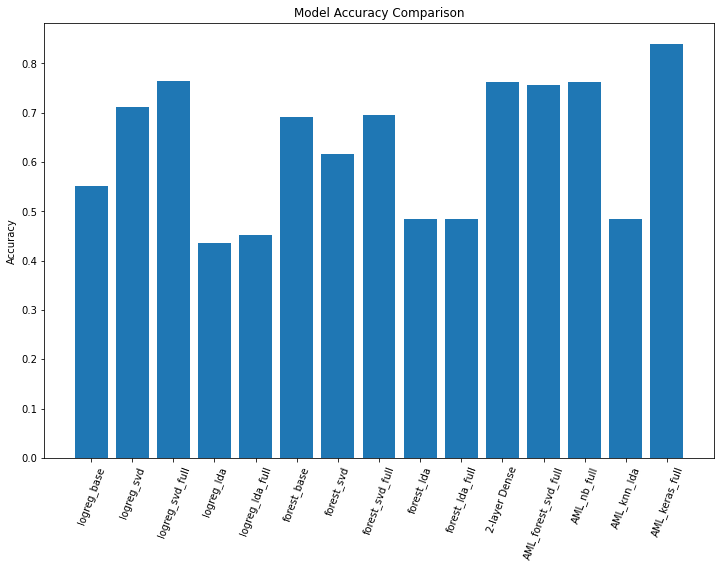

In [151]:
# Final comparison
accuracy_values = [logreg_baseline_acc, 
                   logreg_svd_acc, 
                   logreg_svd_full_acc, 
                   logreg_lda_acc, 
                   logreg_lda_full_acc,
                   
                   forest_baseline_acc, 
                   forest_svd_acc, 
                   forest_svd_full_acc, 
                   forest_lda_acc,
                   forest_lda_full_acc, 
                   
                   keras_svd_full_acc, 

                   forest_tpot_svd_full_acc, 
                   multinomial_nb_tfidf_acc, 
                   KNN_LDA,
                   auto_keras_acc
                  ]

titles = ['logreg_base', 
          'logreg_svd',
          'logreg_svd_full',
          'logreg_lda',
          'logreg_lda_full',
          
          'forest_base', 
          'forest_svd', 
          'forest_svd_full', 
          'forest_lda',
          'forest_lda_full', 
          
          '2-layer Dense', 
        
         'AML_forest_svd_full',
         'AML_nb_full',  
         'AML_knn_lda',
         'AML_keras_full',
         ]

xcor = np.arange(len(accuracy_values))
plt.figure(figsize=(12,8))
plt.title('Model Accuracy Comparison')
plt.bar(xcor, accuracy_values)
plt.xticks(xcor, titles, rotation=70)
plt.ylabel('Accuracy')
plt.show()

It is show time!

Above you can find a visual representation of the Accuracy levels across all the models tested. 
I did not sort the values from the biggest to the lowest, as I have kept the logical distribution of the models tested in this notebook.

We can see that the Logistic Regression on the Truncated Tf-idf vectors and the 2-layers Dense network still on the Truncated Tf-idf vectors are demonstrating the higest scores among all the models I have tuned hyperparameters. 

Clearly, if we also take into consideration the Auto Machine Learning (AML in the graph) models, the Keras CNN on raw text scores the highest among all the models tested.

Overall the results are quite encouraging and I am very satisfied with them!

